<a href="https://colab.research.google.com/github/mitresthen/phys117_2021/blob/main/CNNSphaleronBlackhole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import DatasetFolder
from torch.utils.data import WeightedRandomSampler
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import seaborn as sns
from pathlib import Path

from PIL import Image


plt.ion()   # interactive mode

In [ ]:
def pil_loader(path: str):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, "rb") as f:
        img = Image.open(f)
        return img.convert("RGB")

def default_loader(path: str):
    from torchvision import get_image_backend

    if get_image_backend() == "accimage":
        return accimage_loader(path)
    else:
        return pil_loader(path)

def find_classes(directory: str, subdirs):
    """Finds the class folders in a dataset.
    See :class:`DatasetFolder` for details.
    """
    classes = sorted(entry.name for entry in os.scandir(directory) if (entry.is_dir() and entry.name in subdirs) )
    if not classes:
        raise FileNotFoundError(f"Couldn't find any class folder in {directory}.")

    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

IMG_EXTENSIONS = (".jpg", ".jpeg", ".png", ".ppm", ".bmp", ".pgm", ".tif", ".tiff", ".webp")


class ImageFolderCustom(DatasetFolder):
    def __init__(
        self,
        root: str,
        subdirs,
        transform = None,
        target_transform = None,
        loader = default_loader,
        is_valid_file = None,
    ):
        self.subdirs = subdirs
        super().__init__(
            root,
            loader,
            IMG_EXTENSIONS if is_valid_file is None else None,
            transform=transform,
            target_transform=target_transform,
            is_valid_file=is_valid_file,
        )
        self.imgs = self.samples

    def find_classes(self, directory):
      return find_classes(directory, self.subdirs)


In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


In [ ]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, device, dataset_sizes, num_epochs=25):
    print(f"training on {device} ")
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            iteration = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                iteration += 1
                if(iteration % 1000 == 0):
                  print(f"on iteration {iteration}")
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, dataloaders, device, class_names, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}, actual: {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


In [ ]:
def makeModelWithBH(bh_folder, data_dir):
  modelFileName = f"model_trained_{bh_folder}_r34_e10.pt"
  if (Path(modelFileName).is_file()):
    return
  subdirs = ["PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", "ttbar", "ttbar_largejets"]
  subdirs.append(bh_folder)

  image_datasets = {x: ImageFolderCustom(os.path.join(data_dir, x), subdirs,
                                          data_transforms[x])
                  for x in ['train', 'val']}
  dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                               shuffle=True, num_workers=4)
                for x in ['train', 'val']}
  dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
  class_names = image_datasets['train'].classes

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(class_names)
  for idx, name in enumerate(class_names):
    print(f"{idx}:{name}")

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  
  # Get a batch of training data
  inputs, classes = next(iter(dataloaders['train']))
  # Make a grid from batch
  out = torchvision.utils.make_grid(inputs)

  imshow(out, title=[class_names[x] for x in classes])

  model_ft = models.resnet34(pretrained=True)
  num_ftrs = model_ft.fc.in_features

  model_ft.fc = nn.Linear(num_ftrs, len(class_names))

  model_ft = model_ft.to(device)

  criterion = nn.CrossEntropyLoss()

  # Observe that all parameters are being optimized
  optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

  # Decay LR by a factor of 0.1 every 7 epochs
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

  model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, dataloaders,
                         device, dataset_sizes, num_epochs=10)

  visualize_model(model_ft, dataloaders, device, class_names)

  torch.save(model_ft.state_dict(), modelFileName)

data_dir = 'generatedData'
bh_folders = sorted(entry.name for entry in os.scandir(f"{data_dir}/train") if (entry.is_dir() and ( entry.name.startswith("BH") or entry.name.startswith("BlackHole") )))
for folders in bh_folders:
  makeModelWithBH(folders, data_dir)


['BH_n4_M10', 'PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL', 'ttbar', 'ttbar_largejets']
for model_trained_BH_n4_M10_r34_e10.pt: Got 6234 / 7200 with accuracy 86.58%


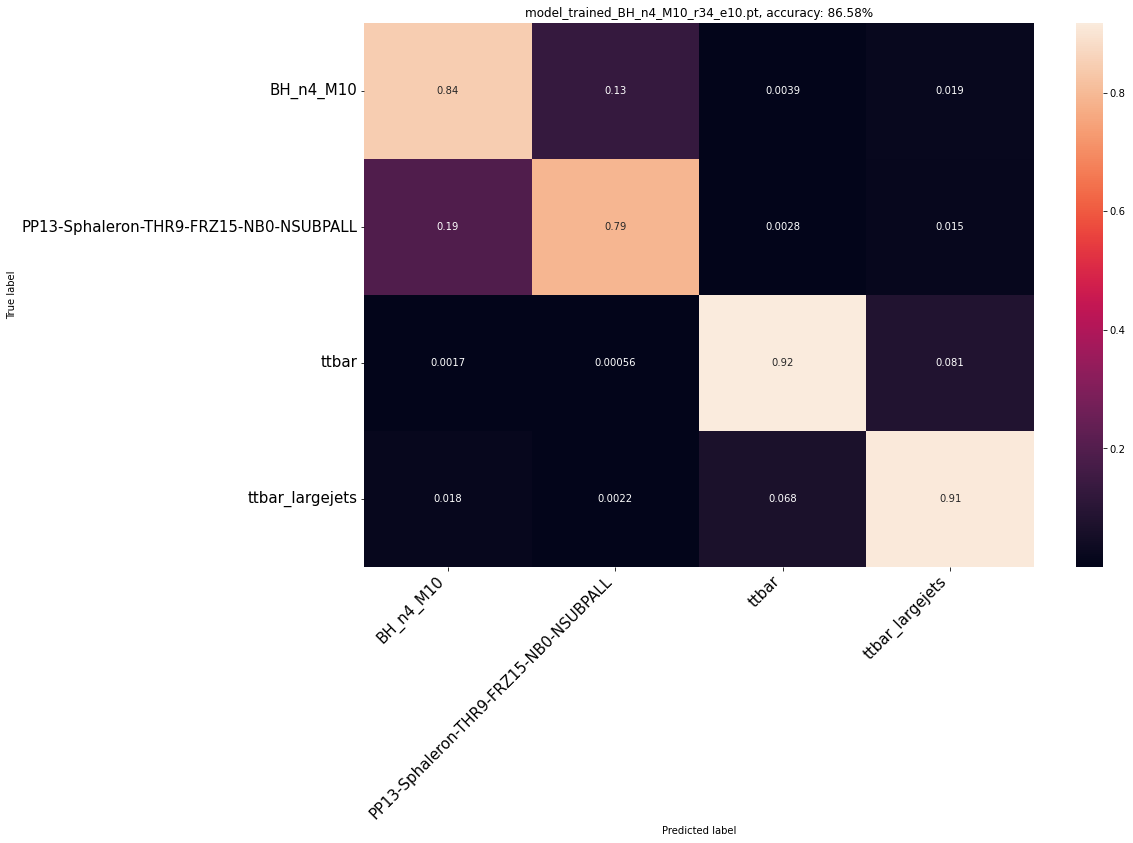

['BH_n4_M11', 'PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL', 'ttbar', 'ttbar_largejets']
for model_trained_BH_n4_M11_r34_e10.pt: Got 6201 / 7200 with accuracy 86.12%


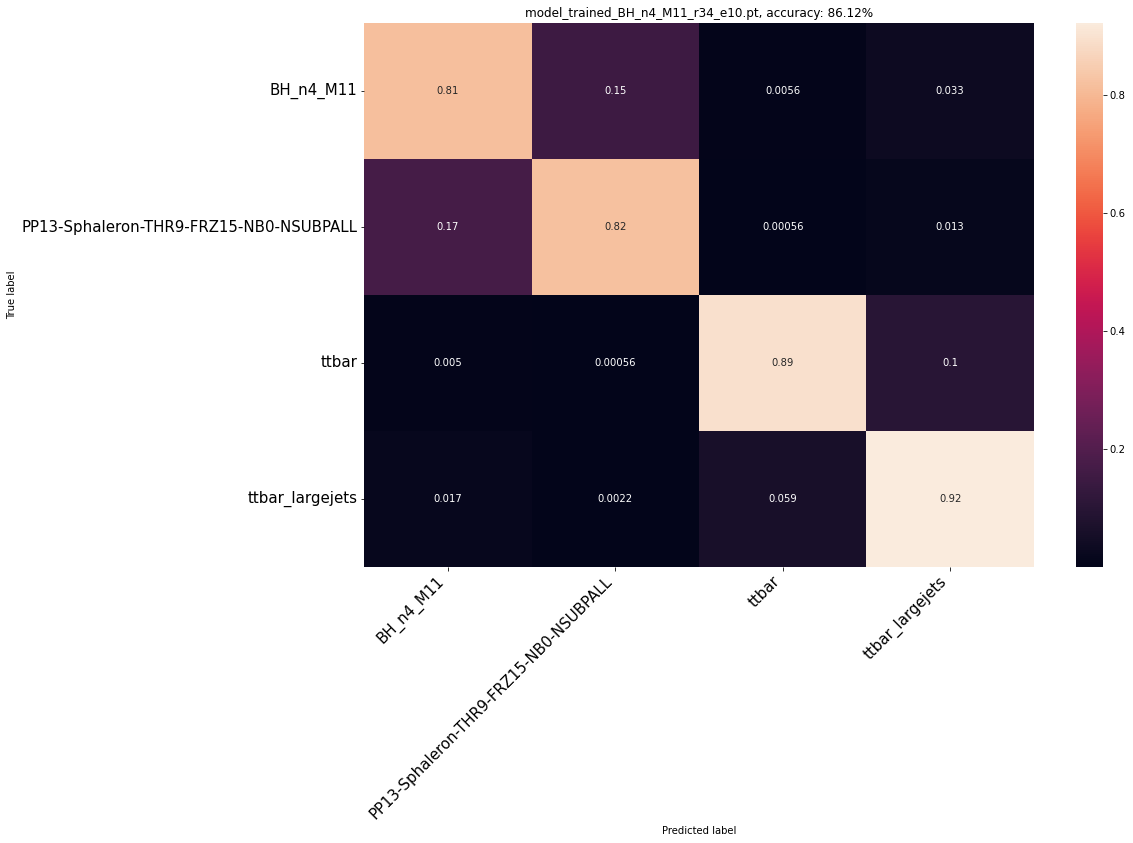

['BH_n4_M12', 'PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL', 'ttbar', 'ttbar_largejets']
for model_trained_BH_n4_M12_r34_e10.pt: Got 6289 / 7200 with accuracy 87.35%


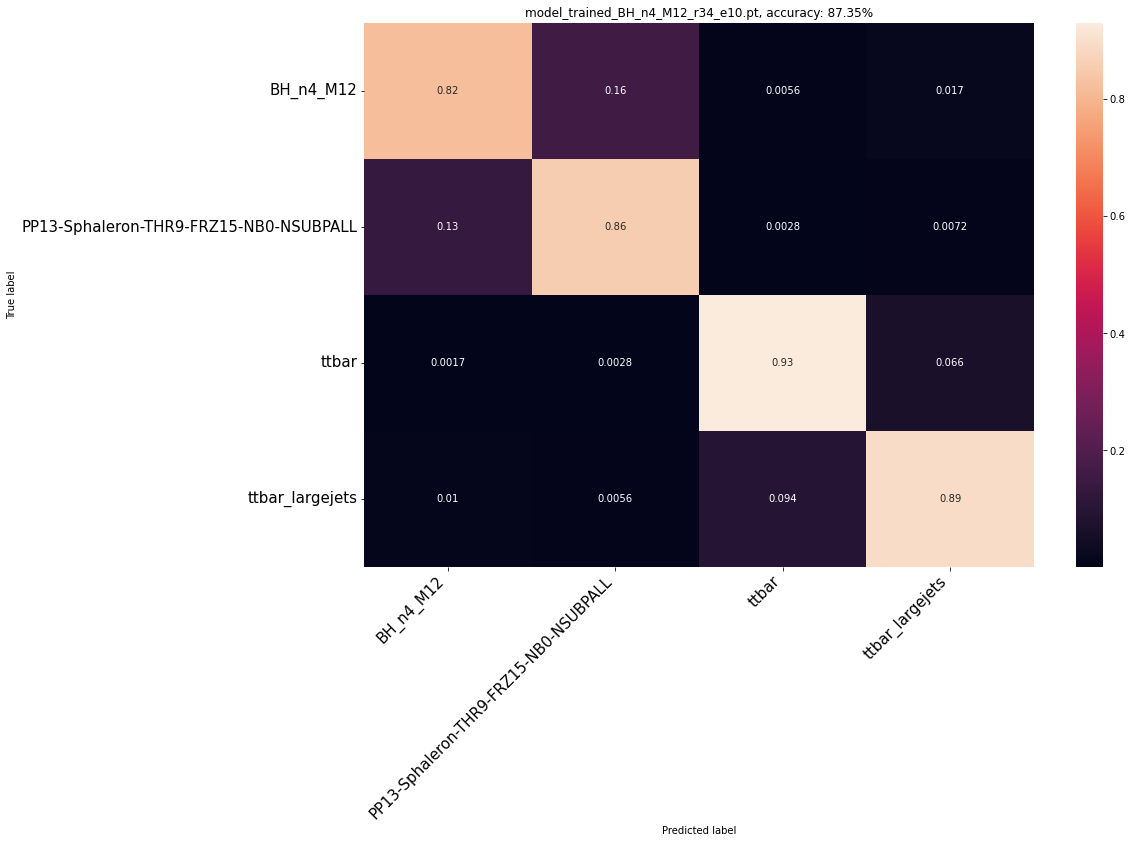

['BH_n4_M8', 'PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL', 'ttbar', 'ttbar_largejets']
for model_trained_BH_n4_M8_r34_e10.pt: Got 6299 / 7200 with accuracy 87.49%


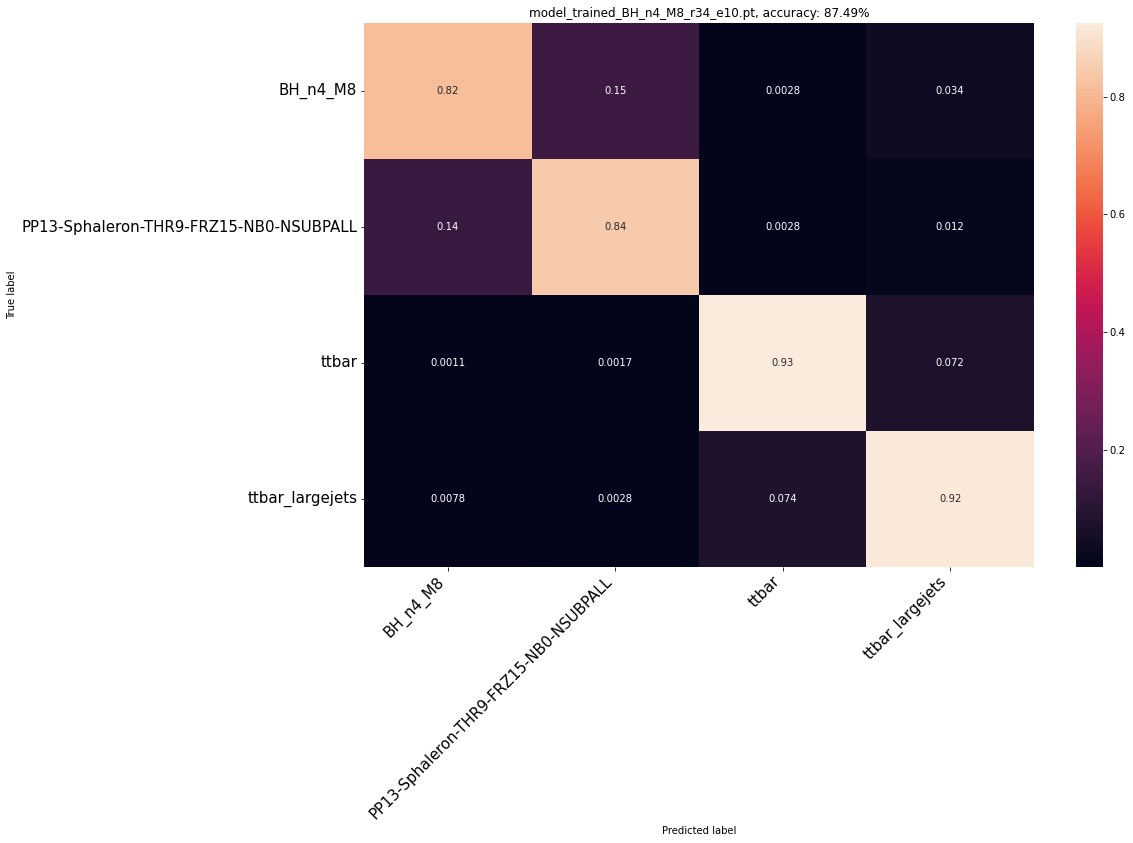

['BH_n4_M9', 'PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL', 'ttbar', 'ttbar_largejets']
for model_trained_BH_n4_M9_r34_e10.pt: Got 6244 / 7200 with accuracy 86.72%


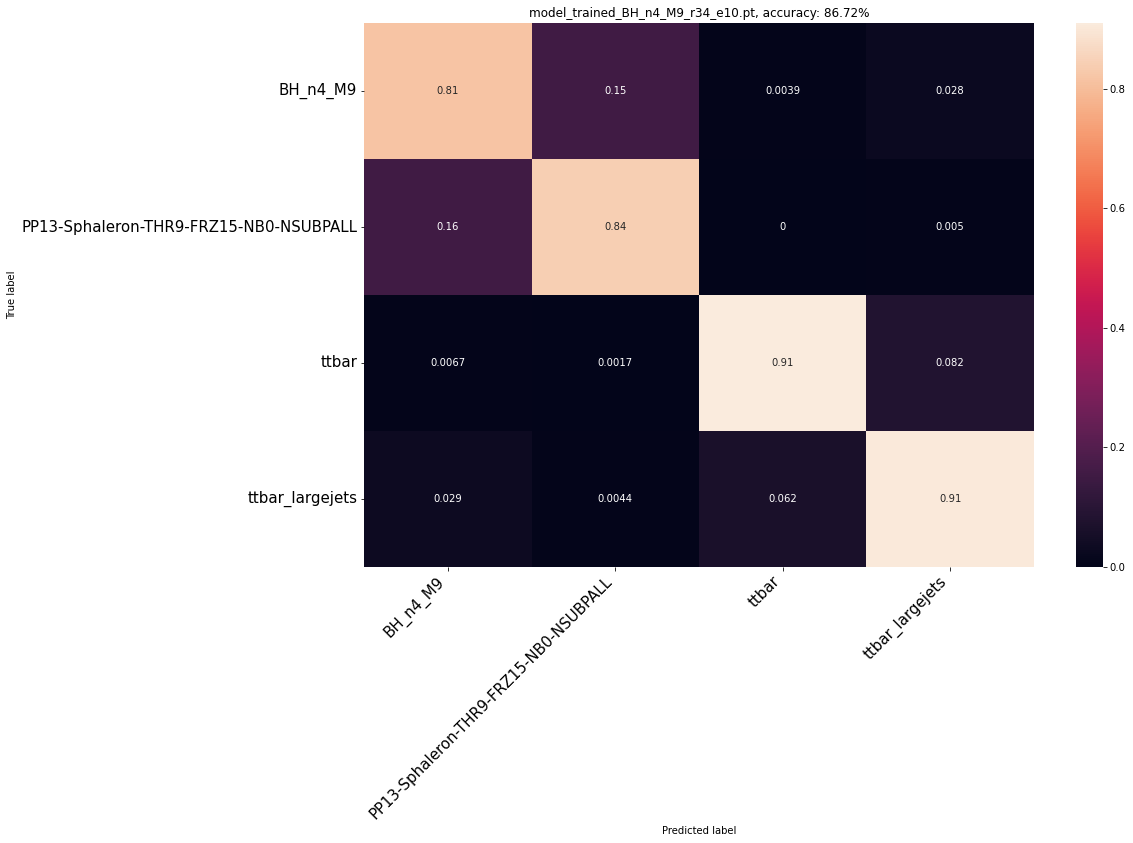

['BH_n5_M10', 'PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL', 'ttbar', 'ttbar_largejets']
for model_trained_BH_n5_M10_r34_e10.pt: Got 6312 / 7200 with accuracy 87.67%


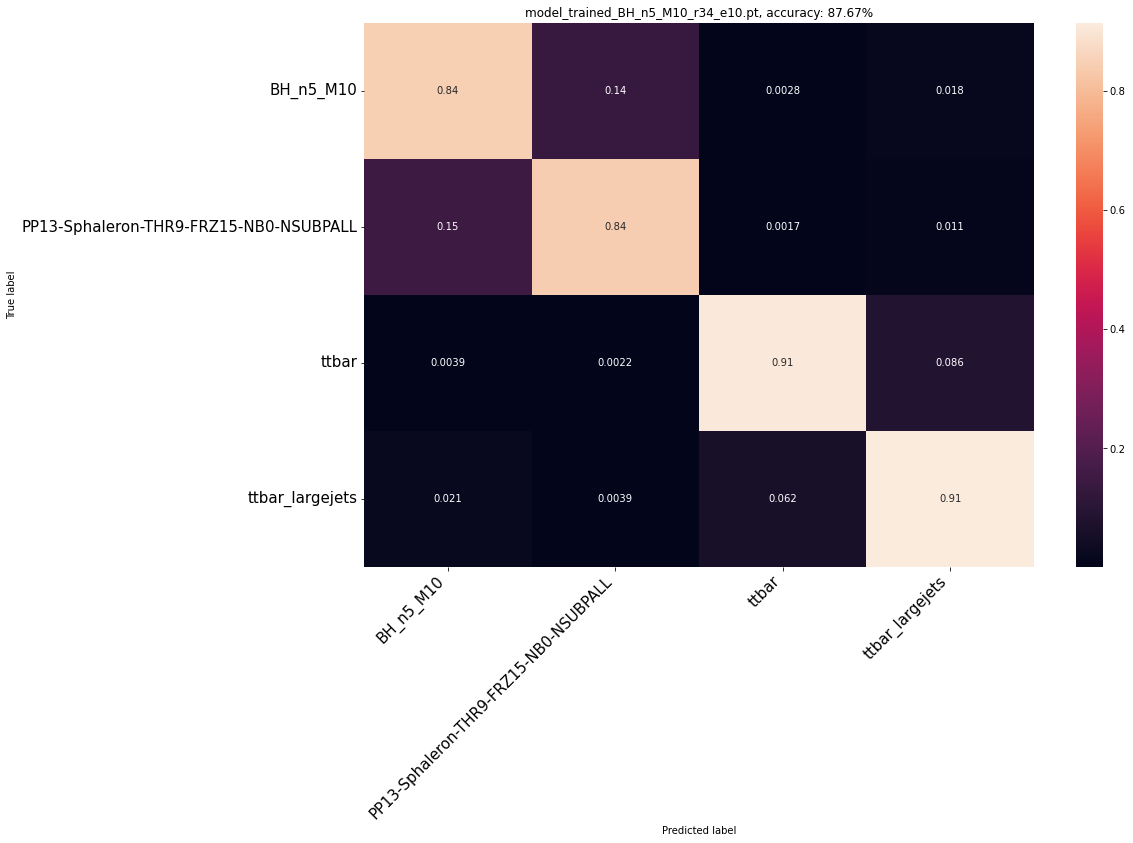

['BH_n5_M11', 'PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL', 'ttbar', 'ttbar_largejets']
for model_trained_BH_n5_M11_r34_e10.pt: Got 6300 / 7200 with accuracy 87.50%


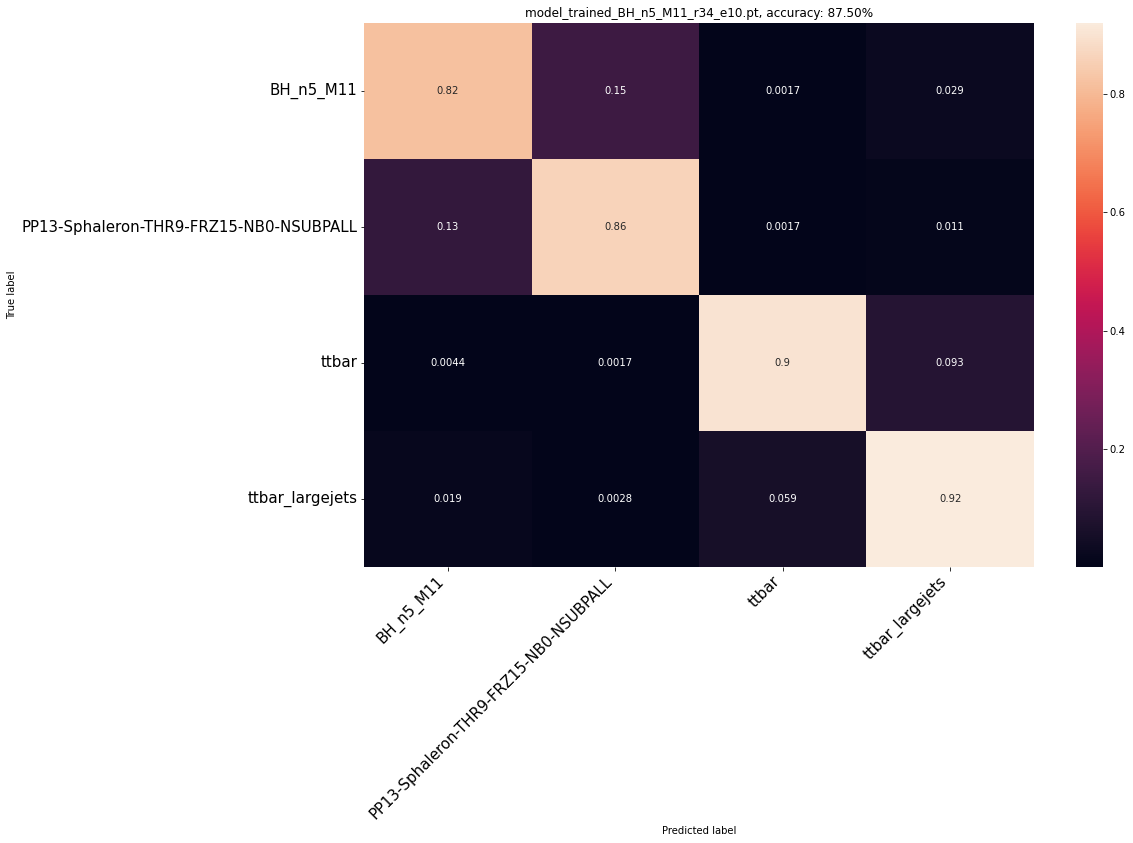

['BH_n5_M12', 'PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL', 'ttbar', 'ttbar_largejets']
for model_trained_BH_n5_M12_r34_e10.pt: Got 6303 / 7200 with accuracy 87.54%


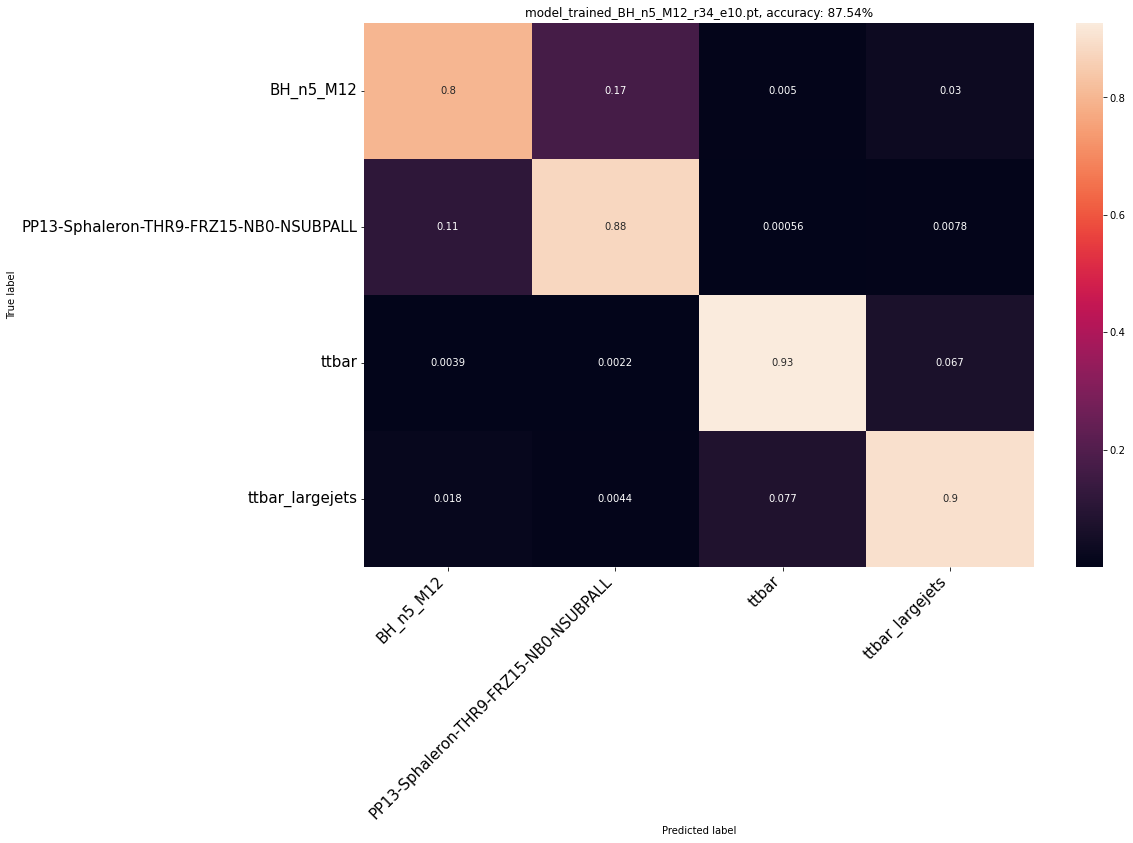

['BH_n5_M8', 'PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL', 'ttbar', 'ttbar_largejets']
for model_trained_BH_n5_M8_r34_e10.pt: Got 6257 / 7200 with accuracy 86.90%


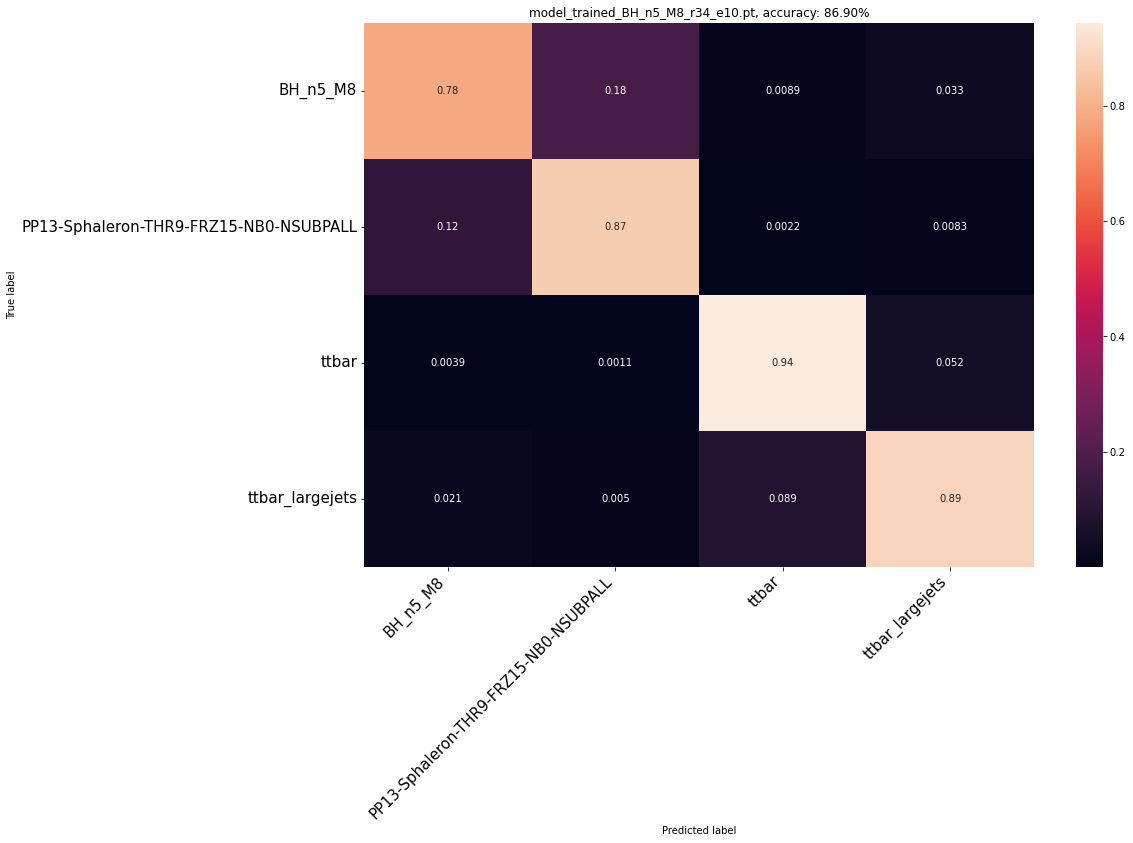

['BH_n5_M9', 'PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL', 'ttbar', 'ttbar_largejets']
for model_trained_BH_n5_M9_r34_e10.pt: Got 6260 / 7200 with accuracy 86.94%


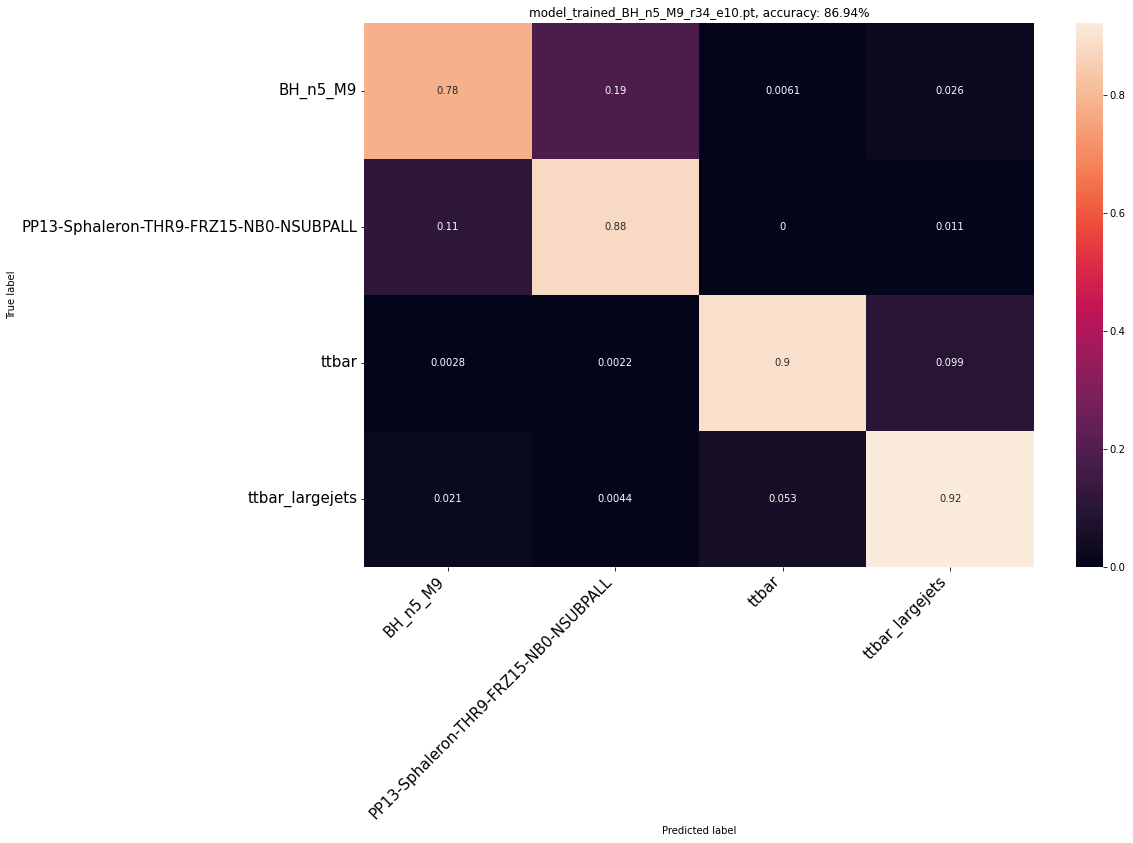

['BH_n6_M10', 'PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL', 'ttbar', 'ttbar_largejets']
for model_trained_BH_n6_M10_r34_e10.pt: Got 6331 / 7200 with accuracy 87.93%


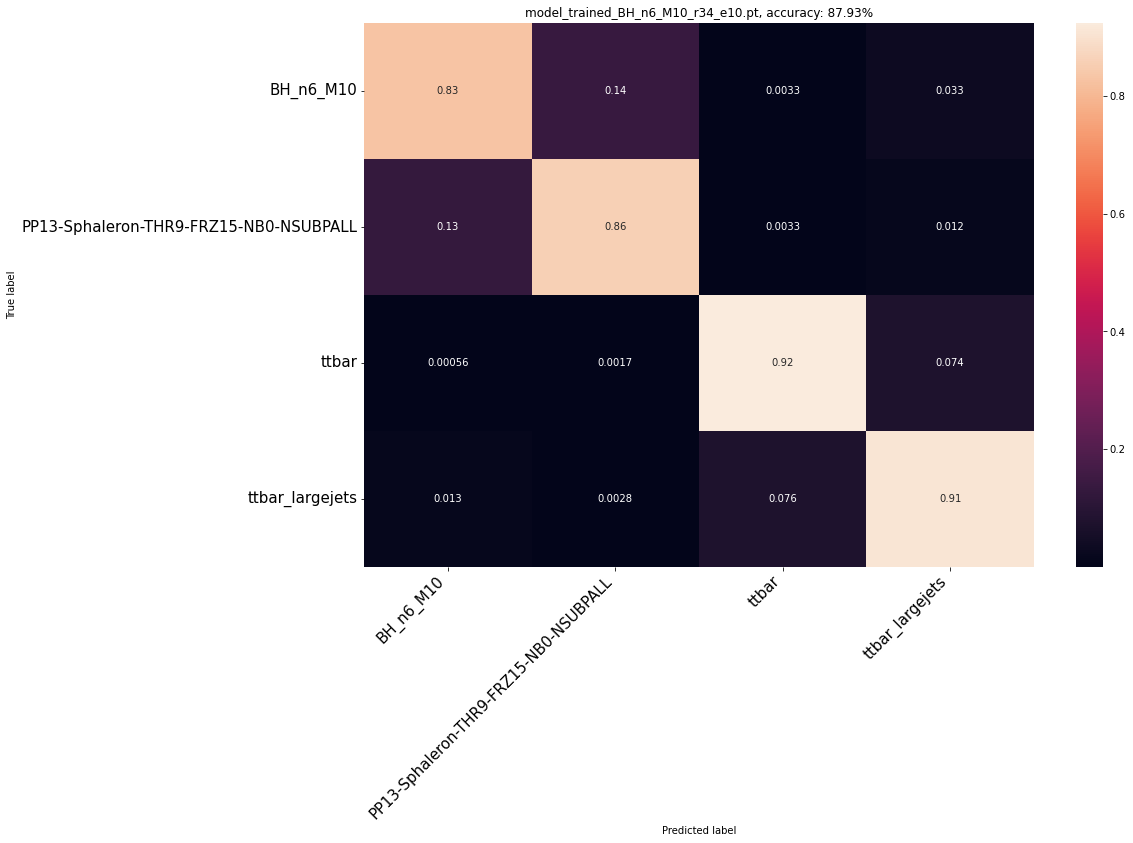

['BH_n6_M11', 'PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL', 'ttbar', 'ttbar_largejets']
for model_trained_BH_n6_M11_r34_e10.pt: Got 6301 / 7200 with accuracy 87.51%


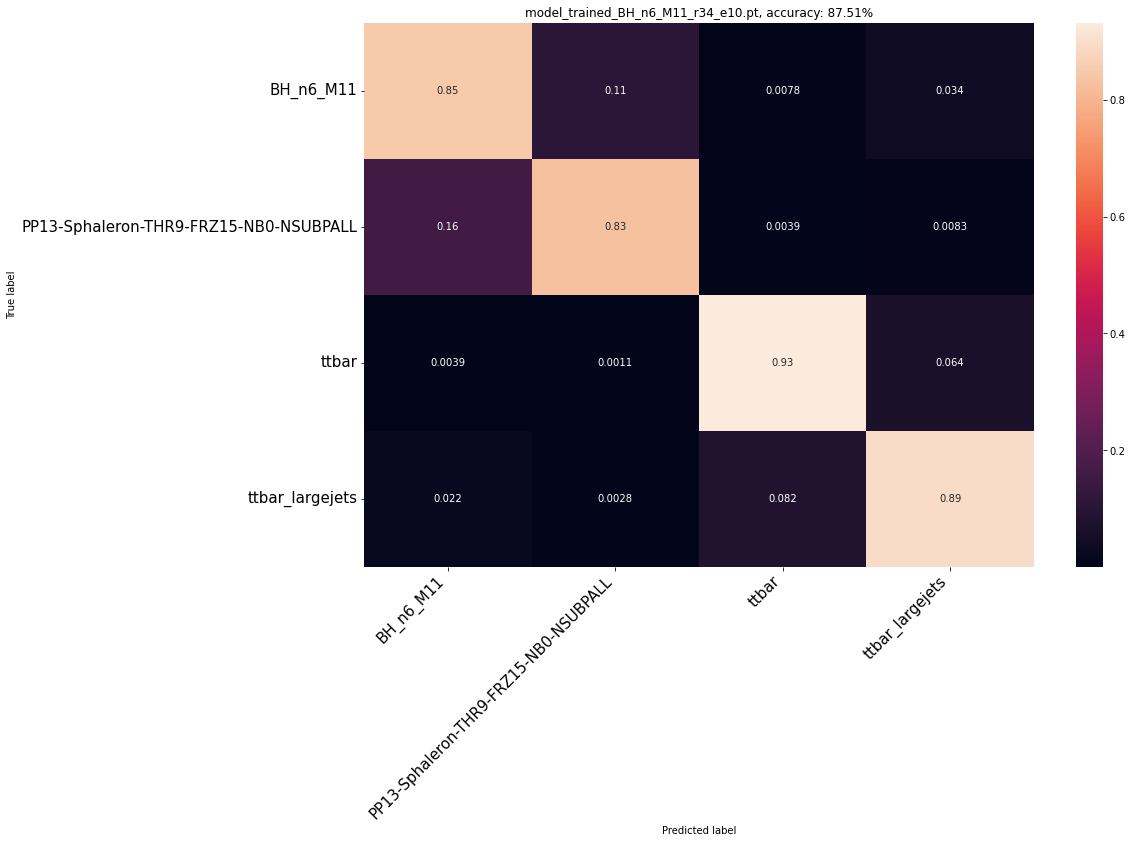

['BH_n6_M12', 'PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL', 'ttbar', 'ttbar_largejets']
for model_trained_BH_n6_M12_r34_e10.pt: Got 6349 / 7200 with accuracy 88.18%


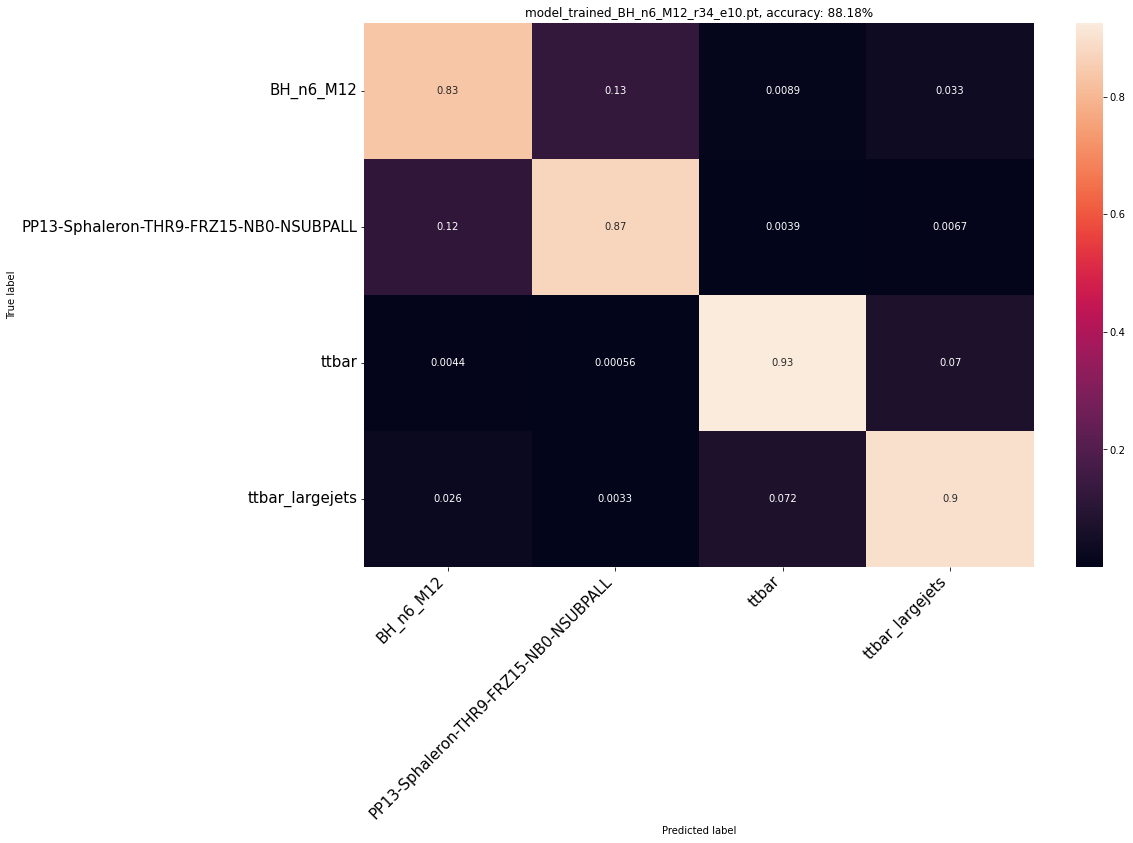

['BH_n6_M8', 'PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL', 'ttbar', 'ttbar_largejets']
for model_trained_BH_n6_M8_r34_e10.pt: Got 6534 / 7200 with accuracy 90.75%


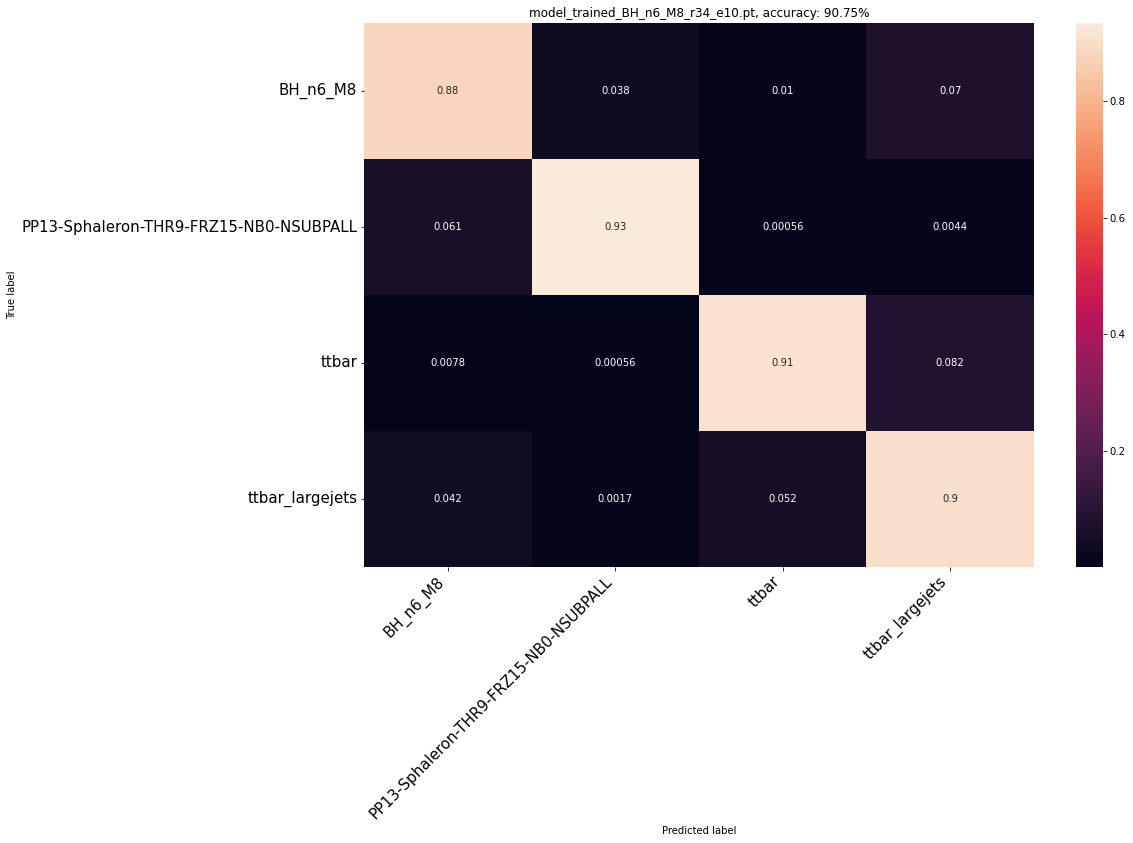

['BH_n6_M9', 'PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL', 'ttbar', 'ttbar_largejets']
for model_trained_BH_n6_M9_r34_e10.pt: Got 6306 / 7200 with accuracy 87.58%


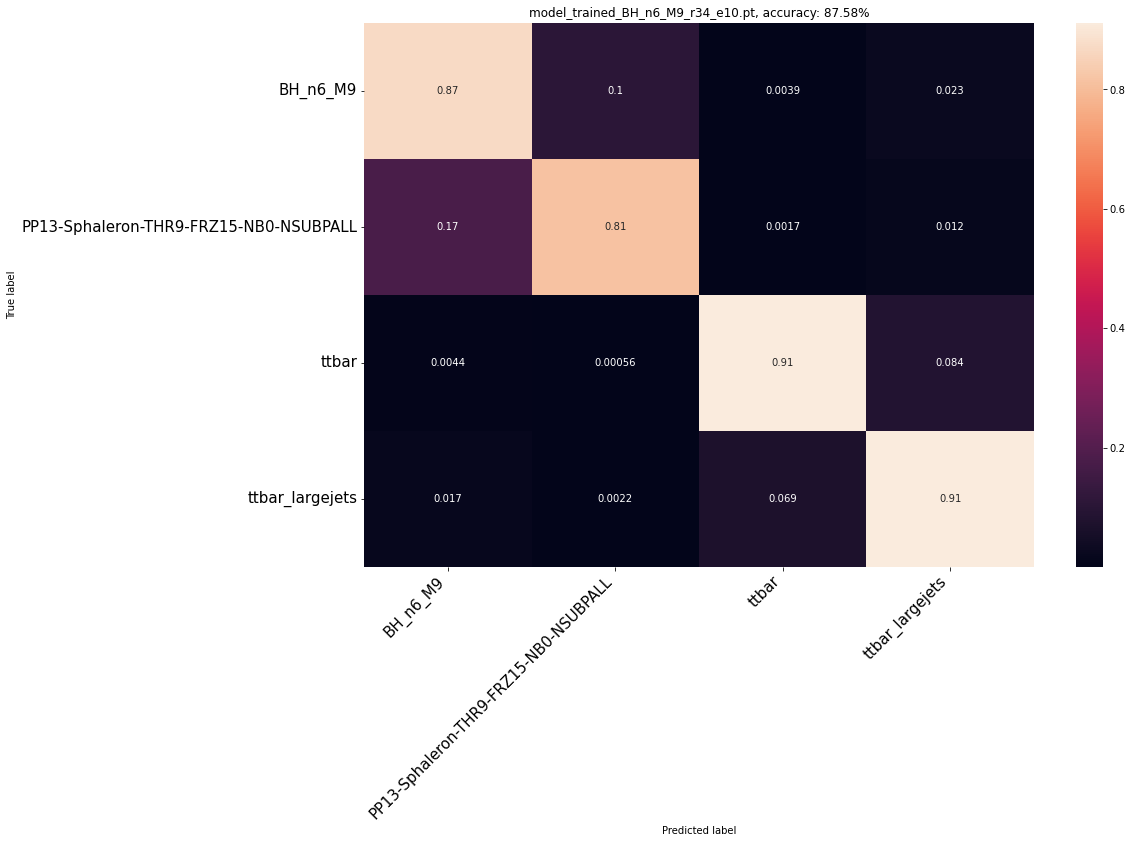

In [ ]:
from torchvision.models import ResNet
data_dir = 'generatedData'

def loadAndPlot(folder, loaded_model):
  valDataDir = f"{data_dir}/val"
  subdirs = [folder, "PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", "ttbar", "ttbar_largejets"]
  image_dataset = ImageFolderCustom(valDataDir, subdirs, transform=data_transforms['val'])

  dataloader = torch.utils.data.DataLoader(image_dataset, batch_size=4,
                                               num_workers=4, shuffle=True)

  dataset_size = len(image_dataset)
  class_names =  image_dataset.classes
  print(class_names)

  model_path = f"model_trained_{folder}_r34_e10.pt"
  if (not Path(model_path).is_file()):
    return
  model_ft = loaded_model
  model_ft.fc = nn.Linear(model_ft.fc.in_features, len(class_names))

  model_ft.load_state_dict(torch.load(model_path))
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  model_ft = model_ft.to(device)

  model_ft.eval()

  nb_classes = len(class_names)

  num_correct = 0
  num_samples = 0

  confusion_matrix = torch.zeros(nb_classes, nb_classes)
  with torch.no_grad():
      for i, (inputs, classes) in enumerate(dataloader):
          inputs = inputs.to(device)
          classes = classes.to(device)
          outputs = model_ft(inputs)
          _, preds = torch.max(outputs, 1)
          for t, p in zip(classes.view(-1), preds.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1
            num_samples += 1
            num_correct += (t == p)


  plt.figure(figsize=(15,10))
  accuracy = f"{float(num_correct)/float(num_samples)*100:.2f}"
  print(f'for {model_path}: Got {num_correct} / {num_samples} with accuracy {accuracy}%') 

  df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
  normalized_df = df_cm.div(df_cm.sum(axis=1), axis=0)
  heatmap = sns.heatmap(normalized_df, annot=True)

  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.title(f"{model_path}, accuracy: {accuracy}%")
  plt.show()

bh_folders = sorted(entry.name for entry in os.scandir(f"{data_dir}/val") if (entry.is_dir() and ( entry.name.startswith("BH") or entry.name.startswith("BlackHole")) )
for folder in bh_folders:
  loadAndPlot(folder, models.resnet34(pretrained=True))
#loadAndPlot("BlackHole", models.resnet50(pretrained=True))

['BH_n4_M10', 'PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL', 'ttbar', 'ttbar_largejets']
['BH_n4_M10', 'BH_n4_M11', 'BH_n4_M12', 'BH_n4_M8', 'BH_n4_M9', 'BH_n5_M10', 'BH_n5_M11', 'BH_n5_M12', 'BH_n5_M8', 'BH_n5_M9', 'BH_n6_M10', 'BH_n6_M11', 'BH_n6_M12', 'BH_n6_M8', 'BH_n6_M9', 'PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL', 'ttbar', 'ttbar_largejets']
for model_trained_BH_n4_M10_r34_e10.pt: Got 26588 / 32400 with accuracy 82.06%


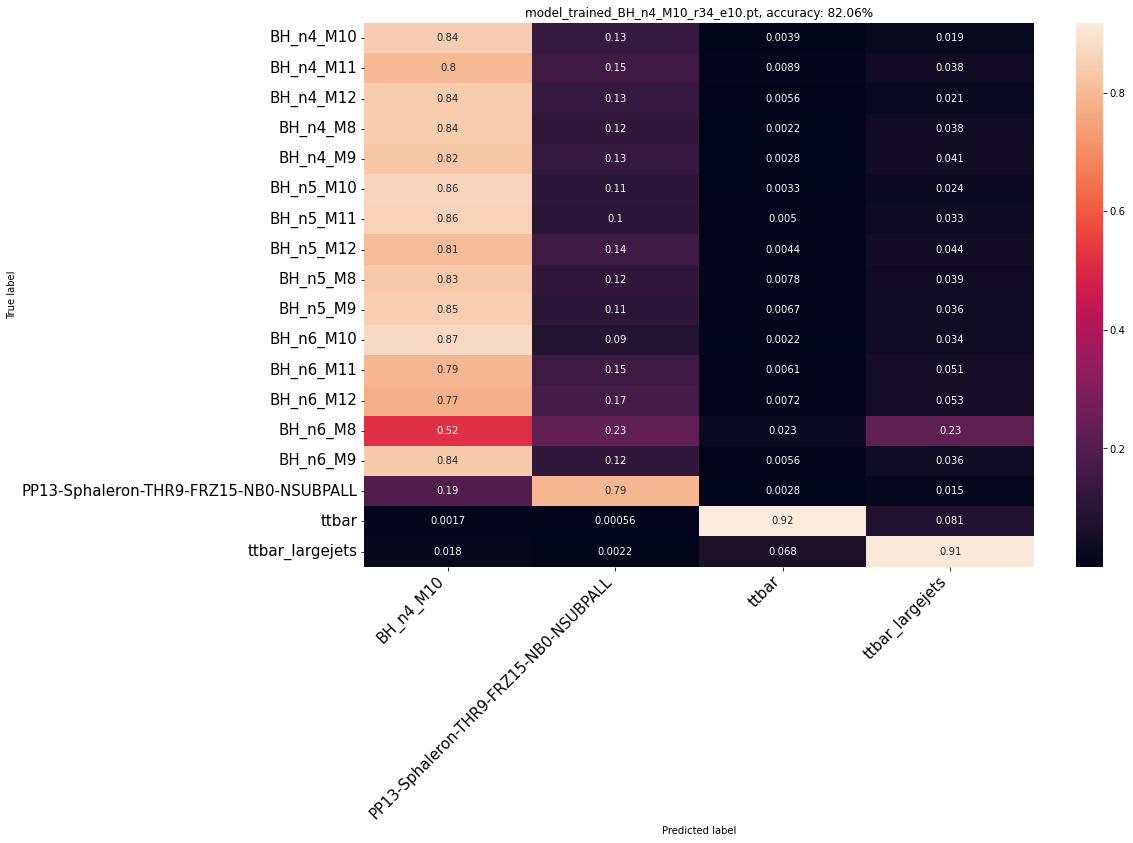

['BH_n4_M11', 'PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL', 'ttbar', 'ttbar_largejets']
['BH_n4_M10', 'BH_n4_M11', 'BH_n4_M12', 'BH_n4_M8', 'BH_n4_M9', 'BH_n5_M10', 'BH_n5_M11', 'BH_n5_M12', 'BH_n5_M8', 'BH_n5_M9', 'BH_n6_M10', 'BH_n6_M11', 'BH_n6_M12', 'BH_n6_M8', 'BH_n6_M9', 'PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL', 'ttbar', 'ttbar_largejets']
for model_trained_BH_n4_M11_r34_e10.pt: Got 26721 / 32400 with accuracy 82.47%


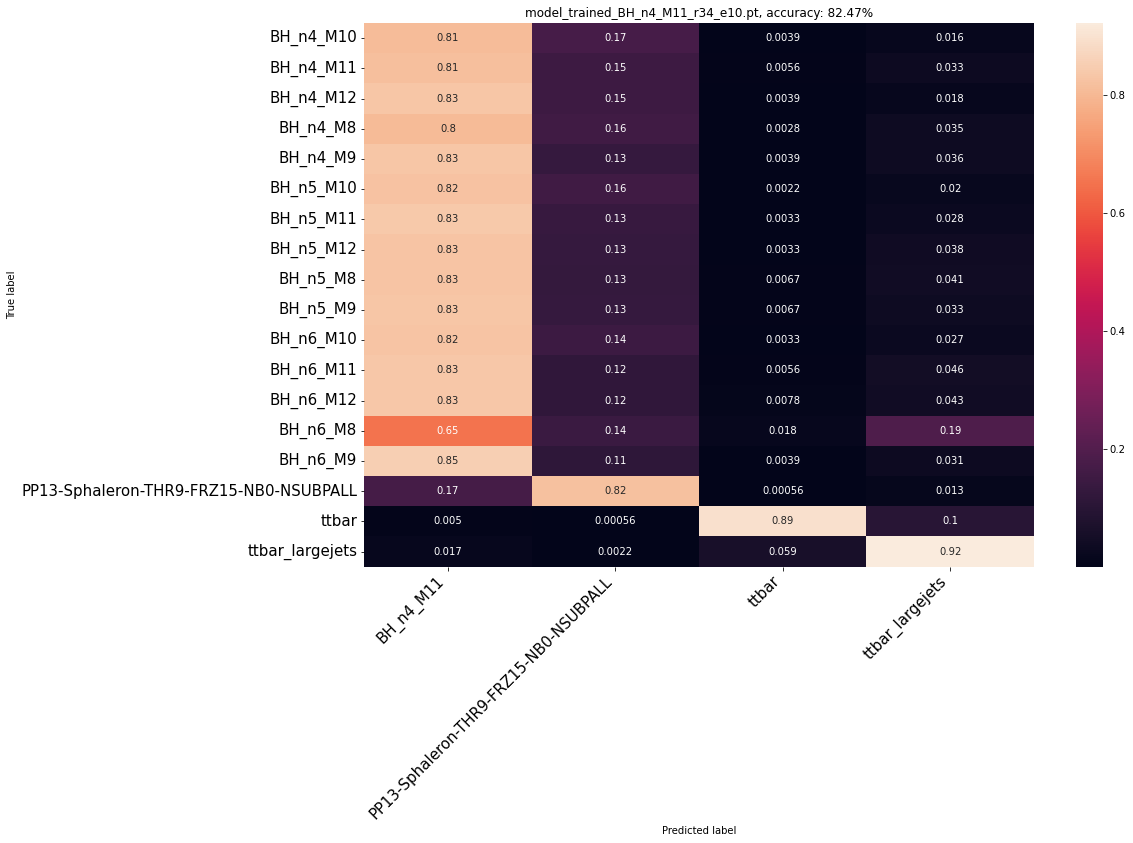

['BH_n4_M12', 'PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL', 'ttbar', 'ttbar_largejets']
['BH_n4_M10', 'BH_n4_M11', 'BH_n4_M12', 'BH_n4_M8', 'BH_n4_M9', 'BH_n5_M10', 'BH_n5_M11', 'BH_n5_M12', 'BH_n5_M8', 'BH_n5_M9', 'BH_n6_M10', 'BH_n6_M11', 'BH_n6_M12', 'BH_n6_M8', 'BH_n6_M9', 'PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL', 'ttbar', 'ttbar_largejets']
for model_trained_BH_n4_M12_r34_e10.pt: Got 25822 / 32400 with accuracy 79.70%


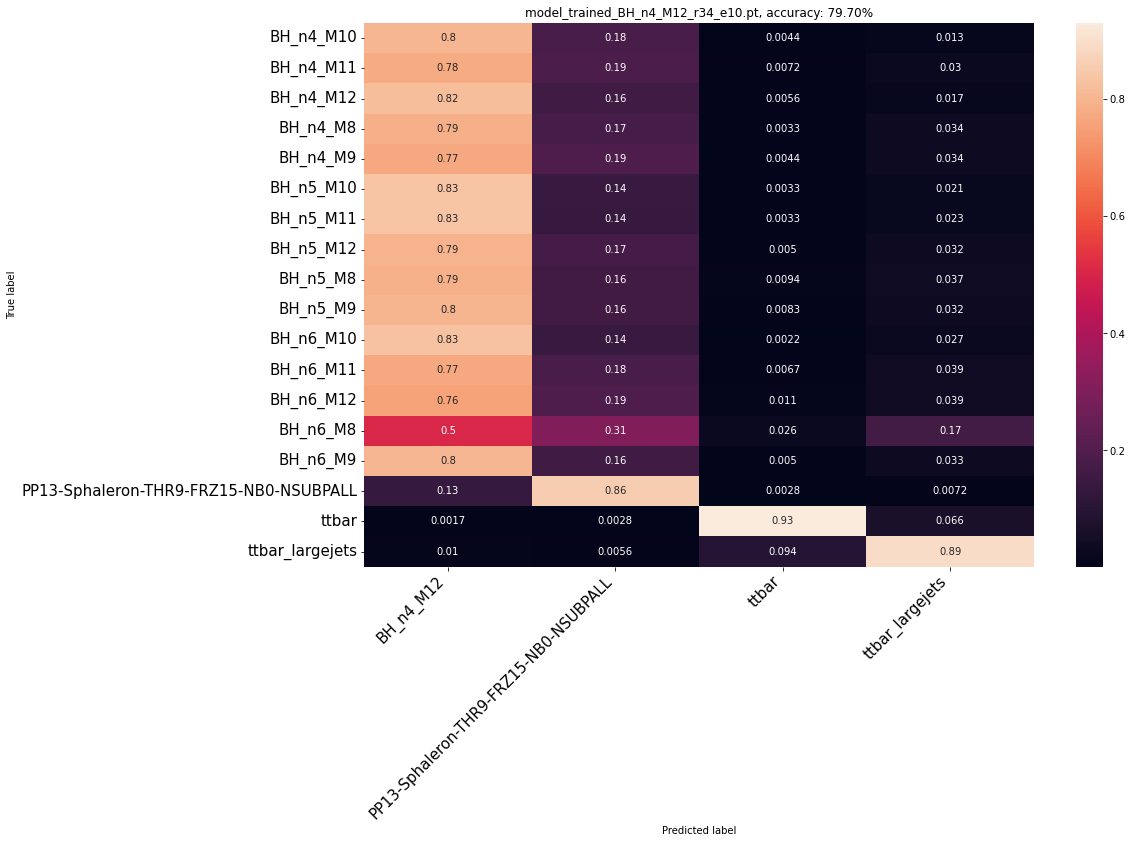

['BH_n4_M8', 'PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL', 'ttbar', 'ttbar_largejets']
['BH_n4_M10', 'BH_n4_M11', 'BH_n4_M12', 'BH_n4_M8', 'BH_n4_M9', 'BH_n5_M10', 'BH_n5_M11', 'BH_n5_M12', 'BH_n5_M8', 'BH_n5_M9', 'BH_n6_M10', 'BH_n6_M11', 'BH_n6_M12', 'BH_n6_M8', 'BH_n6_M9', 'PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL', 'ttbar', 'ttbar_largejets']
for model_trained_BH_n4_M8_r34_e10.pt: Got 25562 / 32400 with accuracy 78.90%


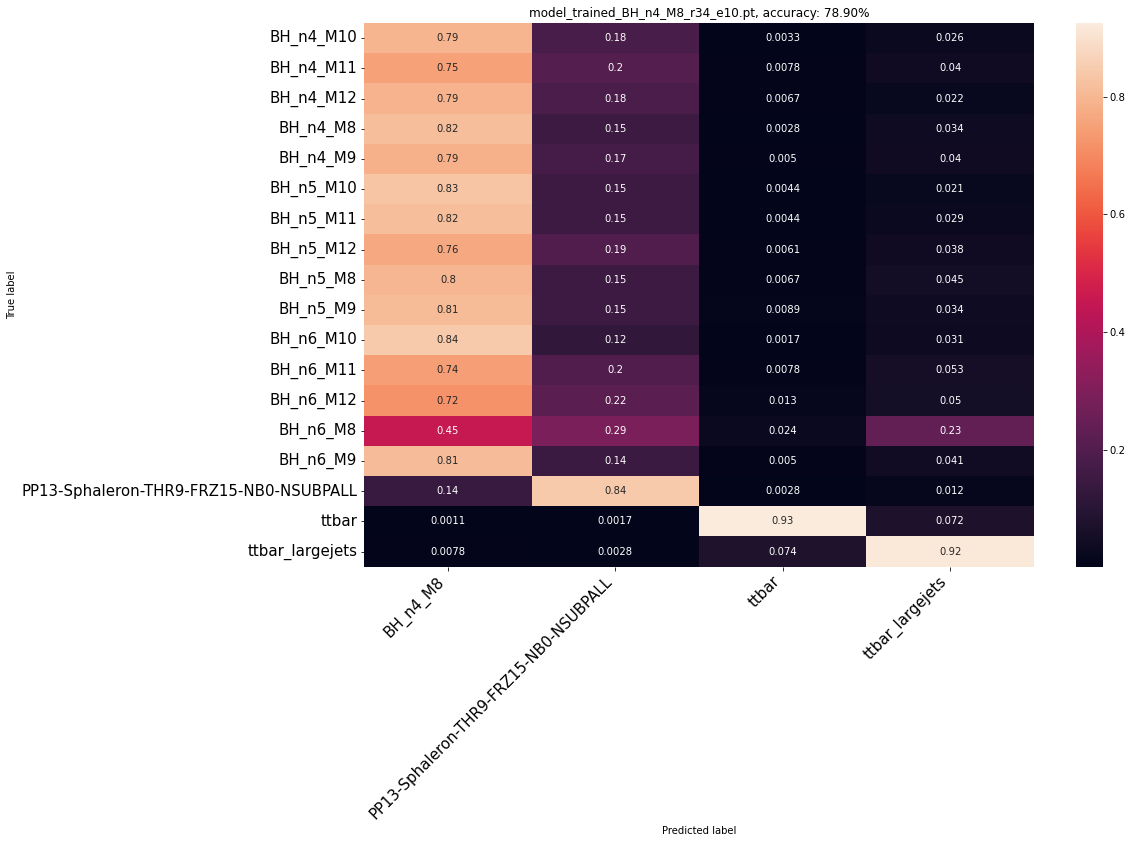

['BH_n4_M9', 'PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL', 'ttbar', 'ttbar_largejets']
['BH_n4_M10', 'BH_n4_M11', 'BH_n4_M12', 'BH_n4_M8', 'BH_n4_M9', 'BH_n5_M10', 'BH_n5_M11', 'BH_n5_M12', 'BH_n5_M8', 'BH_n5_M9', 'BH_n6_M10', 'BH_n6_M11', 'BH_n6_M12', 'BH_n6_M8', 'BH_n6_M9', 'PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL', 'ttbar', 'ttbar_largejets']
for model_trained_BH_n4_M9_r34_e10.pt: Got 26809 / 32400 with accuracy 82.74%


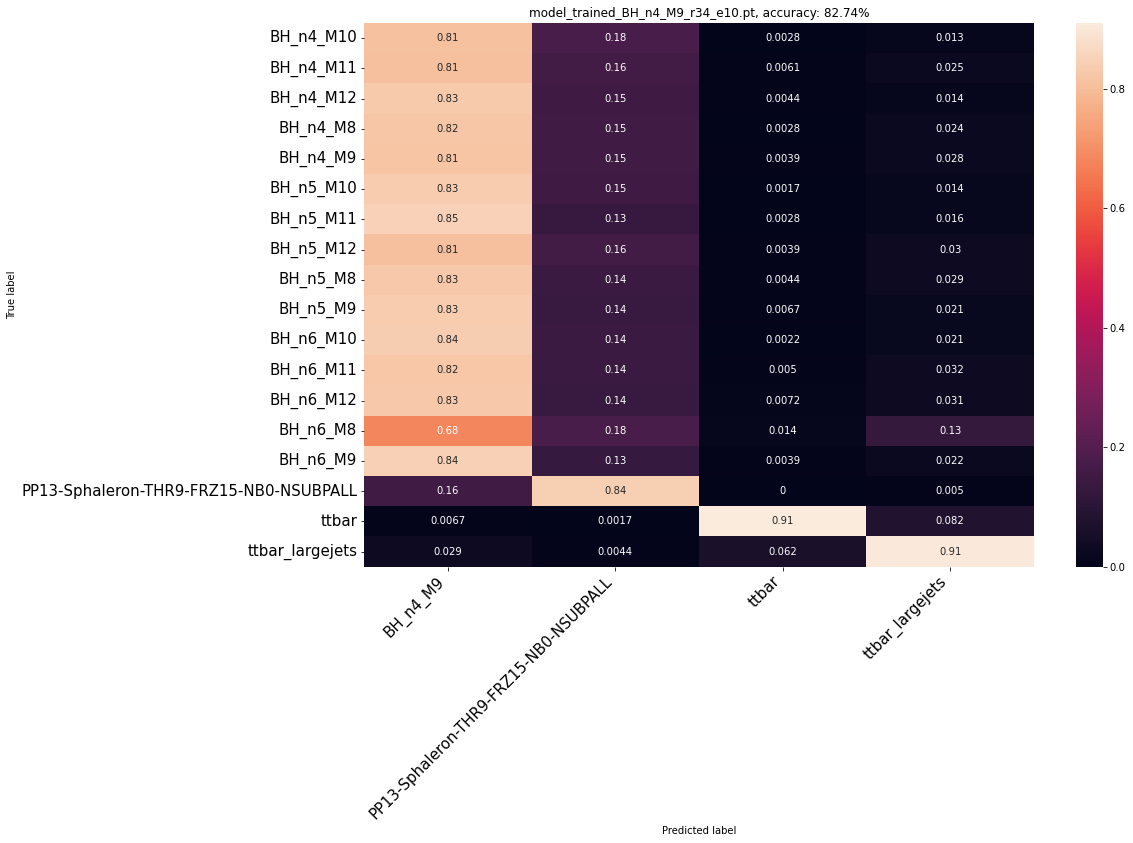

['BH_n5_M10', 'PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL', 'ttbar', 'ttbar_largejets']
['BH_n4_M10', 'BH_n4_M11', 'BH_n4_M12', 'BH_n4_M8', 'BH_n4_M9', 'BH_n5_M10', 'BH_n5_M11', 'BH_n5_M12', 'BH_n5_M8', 'BH_n5_M9', 'BH_n6_M10', 'BH_n6_M11', 'BH_n6_M12', 'BH_n6_M8', 'BH_n6_M9', 'PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL', 'ttbar', 'ttbar_largejets']
for model_trained_BH_n5_M10_r34_e10.pt: Got 25511 / 32400 with accuracy 78.74%


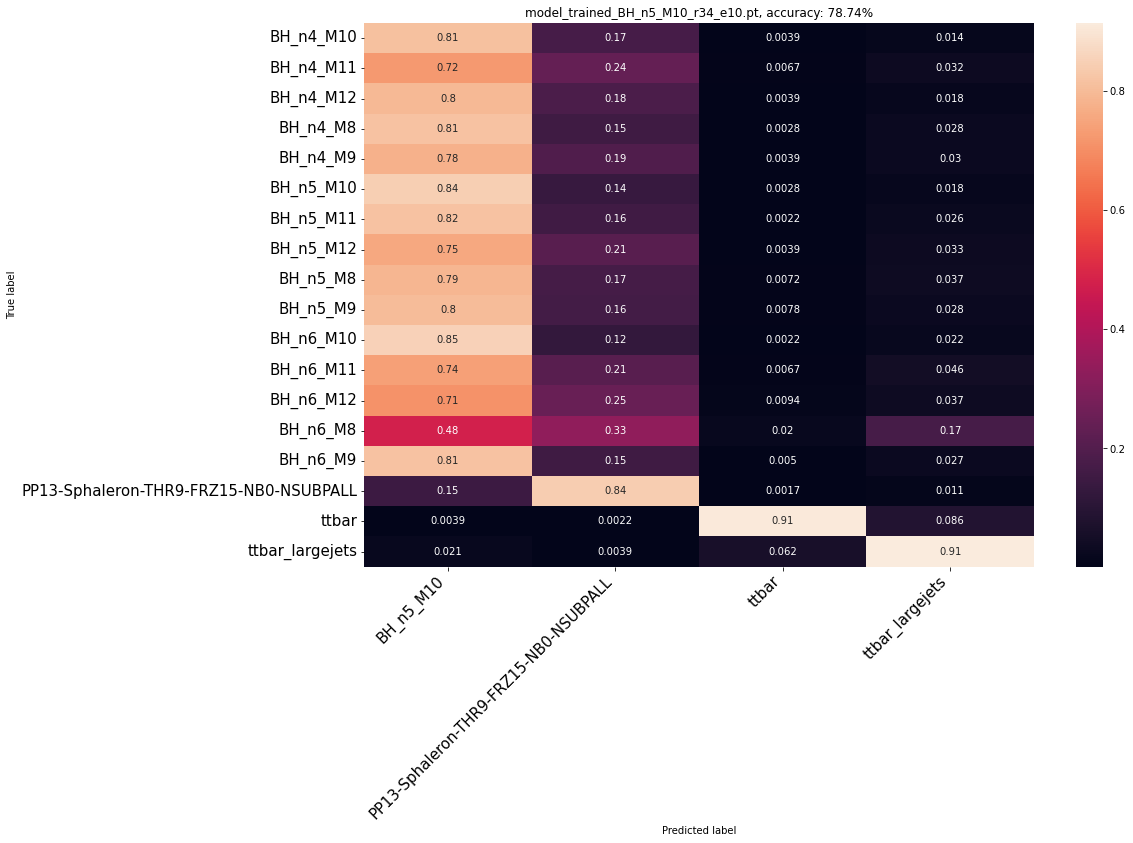

['BH_n5_M11', 'PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL', 'ttbar', 'ttbar_largejets']
['BH_n4_M10', 'BH_n4_M11', 'BH_n4_M12', 'BH_n4_M8', 'BH_n4_M9', 'BH_n5_M10', 'BH_n5_M11', 'BH_n5_M12', 'BH_n5_M8', 'BH_n5_M9', 'BH_n6_M10', 'BH_n6_M11', 'BH_n6_M12', 'BH_n6_M8', 'BH_n6_M9', 'PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL', 'ttbar', 'ttbar_largejets']
for model_trained_BH_n5_M11_r34_e10.pt: Got 25630 / 32400 with accuracy 79.10%


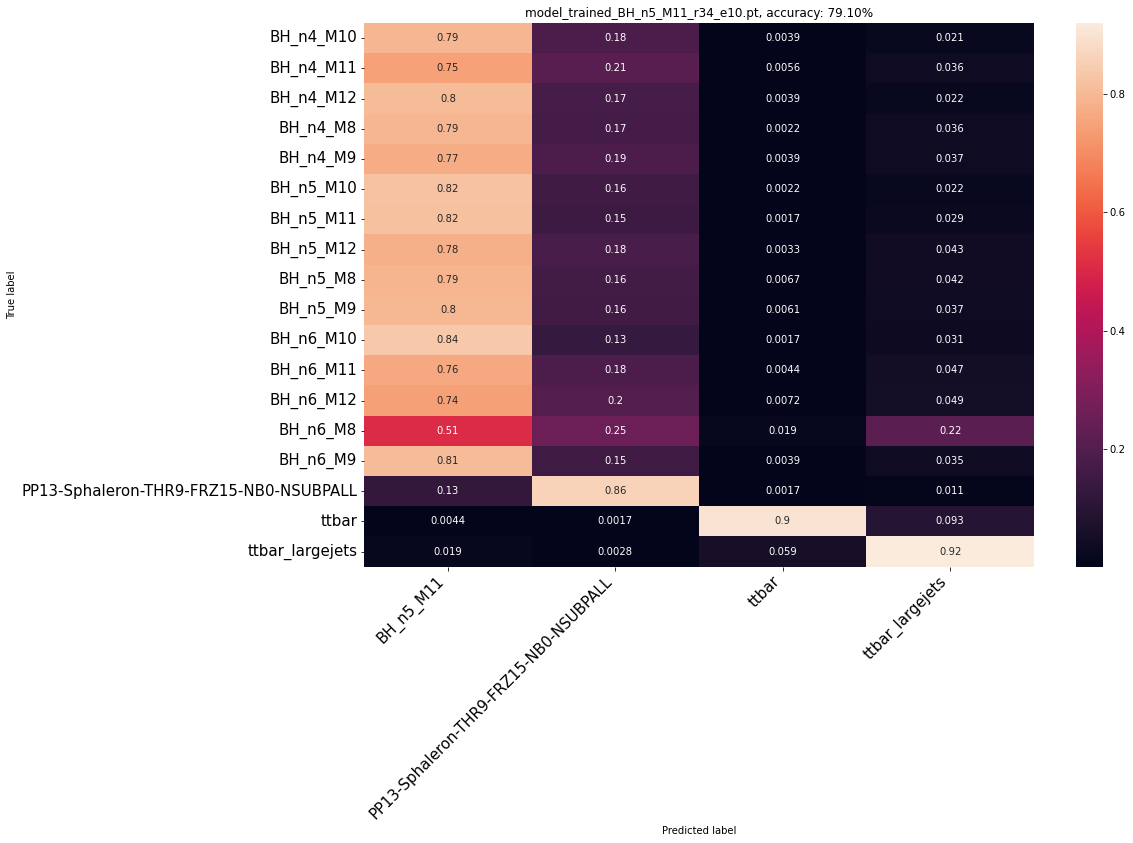

['BH_n5_M12', 'PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL', 'ttbar', 'ttbar_largejets']
['BH_n4_M10', 'BH_n4_M11', 'BH_n4_M12', 'BH_n4_M8', 'BH_n4_M9', 'BH_n5_M10', 'BH_n5_M11', 'BH_n5_M12', 'BH_n5_M8', 'BH_n5_M9', 'BH_n6_M10', 'BH_n6_M11', 'BH_n6_M12', 'BH_n6_M8', 'BH_n6_M9', 'PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL', 'ttbar', 'ttbar_largejets']
for model_trained_BH_n5_M12_r34_e10.pt: Got 24857 / 32400 with accuracy 76.72%


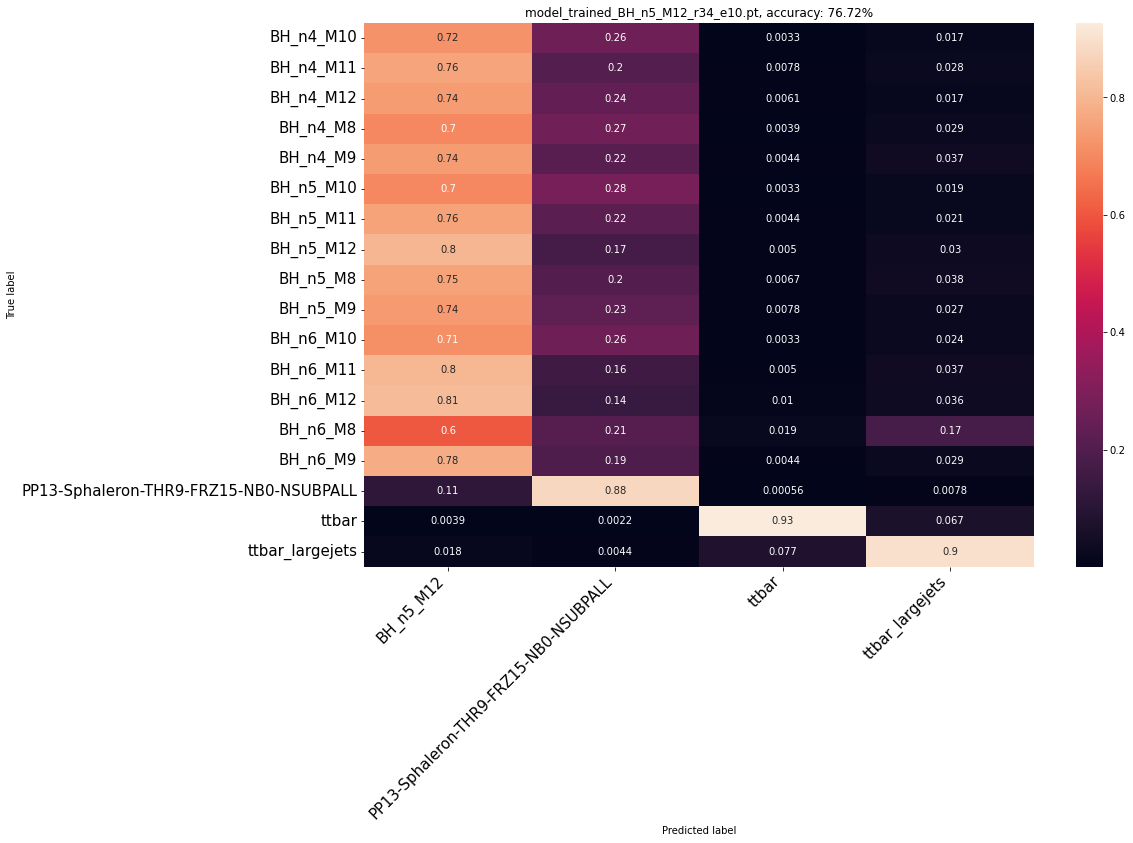

['BH_n5_M8', 'PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL', 'ttbar', 'ttbar_largejets']
['BH_n4_M10', 'BH_n4_M11', 'BH_n4_M12', 'BH_n4_M8', 'BH_n4_M9', 'BH_n5_M10', 'BH_n5_M11', 'BH_n5_M12', 'BH_n5_M8', 'BH_n5_M9', 'BH_n6_M10', 'BH_n6_M11', 'BH_n6_M12', 'BH_n6_M8', 'BH_n6_M9', 'PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL', 'ttbar', 'ttbar_largejets']
for model_trained_BH_n5_M8_r34_e10.pt: Got 25249 / 32400 with accuracy 77.93%


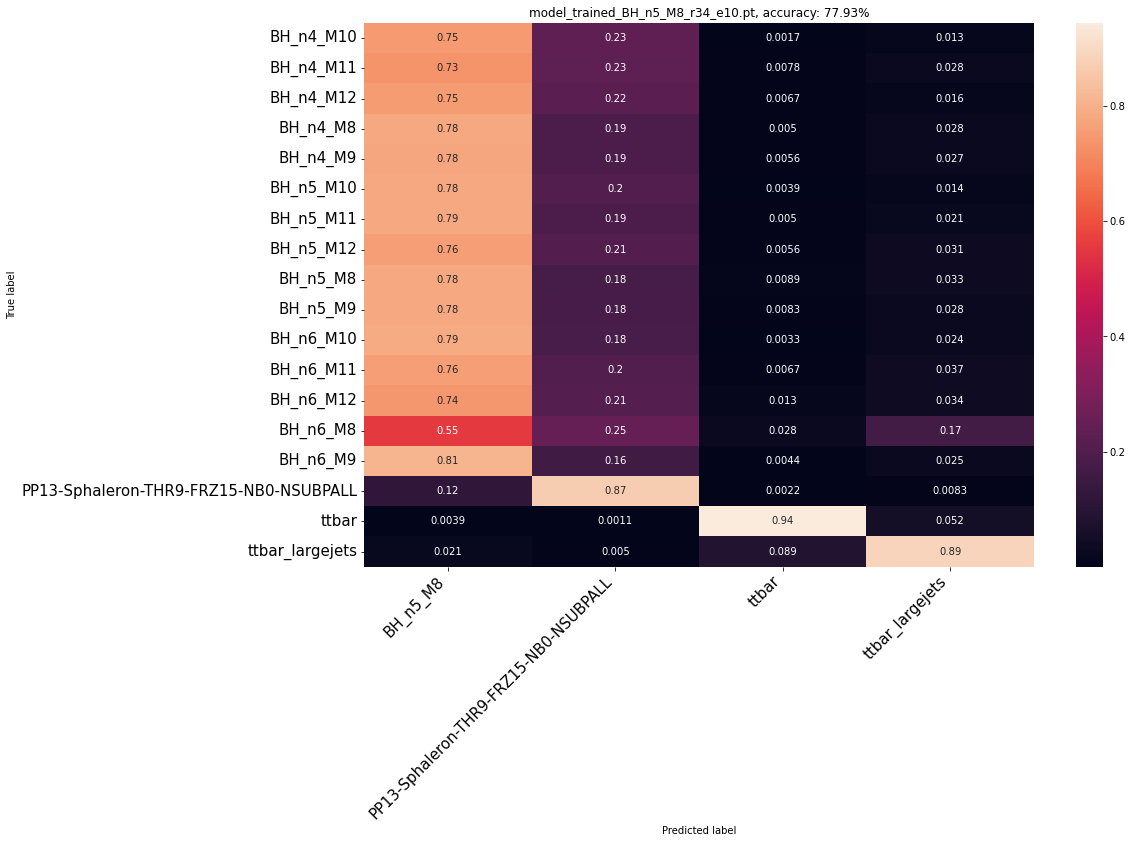

['BH_n5_M9', 'PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL', 'ttbar', 'ttbar_largejets']
['BH_n4_M10', 'BH_n4_M11', 'BH_n4_M12', 'BH_n4_M8', 'BH_n4_M9', 'BH_n5_M10', 'BH_n5_M11', 'BH_n5_M12', 'BH_n5_M8', 'BH_n5_M9', 'BH_n6_M10', 'BH_n6_M11', 'BH_n6_M12', 'BH_n6_M8', 'BH_n6_M9', 'PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL', 'ttbar', 'ttbar_largejets']
for model_trained_BH_n5_M9_r34_e10.pt: Got 25352 / 32400 with accuracy 78.25%


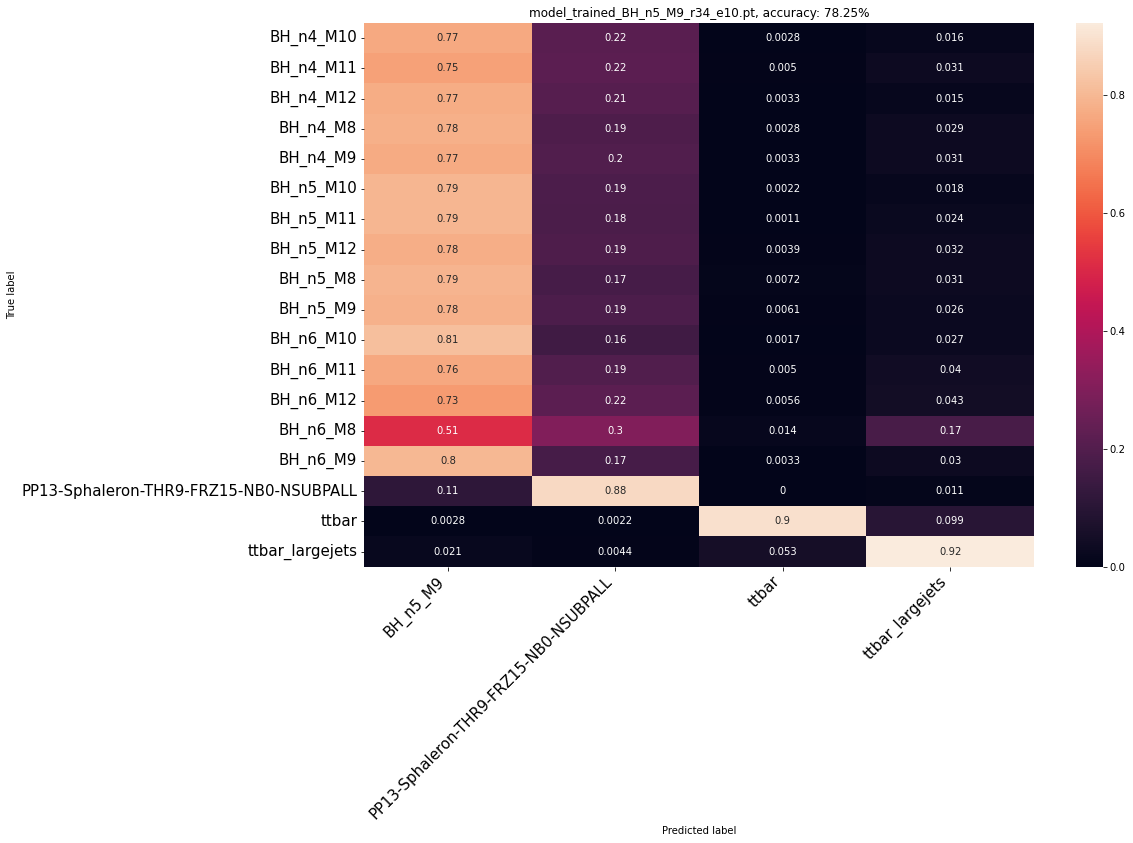

['BH_n6_M10', 'PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL', 'ttbar', 'ttbar_largejets']
['BH_n4_M10', 'BH_n4_M11', 'BH_n4_M12', 'BH_n4_M8', 'BH_n4_M9', 'BH_n5_M10', 'BH_n5_M11', 'BH_n5_M12', 'BH_n5_M8', 'BH_n5_M9', 'BH_n6_M10', 'BH_n6_M11', 'BH_n6_M12', 'BH_n6_M8', 'BH_n6_M9', 'PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL', 'ttbar', 'ttbar_largejets']
for model_trained_BH_n6_M10_r34_e10.pt: Got 24766 / 32400 with accuracy 76.44%


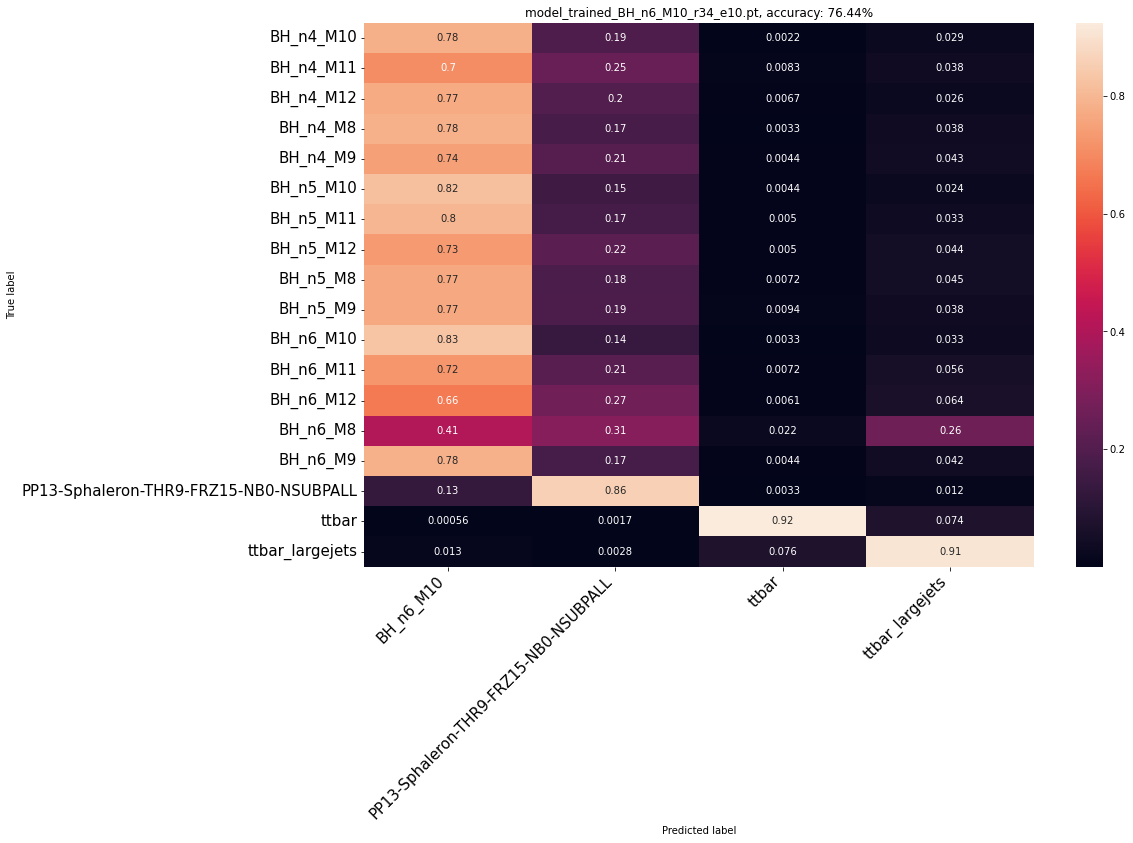

['BH_n6_M11', 'PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL', 'ttbar', 'ttbar_largejets']
['BH_n4_M10', 'BH_n4_M11', 'BH_n4_M12', 'BH_n4_M8', 'BH_n4_M9', 'BH_n5_M10', 'BH_n5_M11', 'BH_n5_M12', 'BH_n5_M8', 'BH_n5_M9', 'BH_n6_M10', 'BH_n6_M11', 'BH_n6_M12', 'BH_n6_M8', 'BH_n6_M9', 'PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL', 'ttbar', 'ttbar_largejets']
for model_trained_BH_n6_M11_r34_e10.pt: Got 26379 / 32400 with accuracy 81.42%


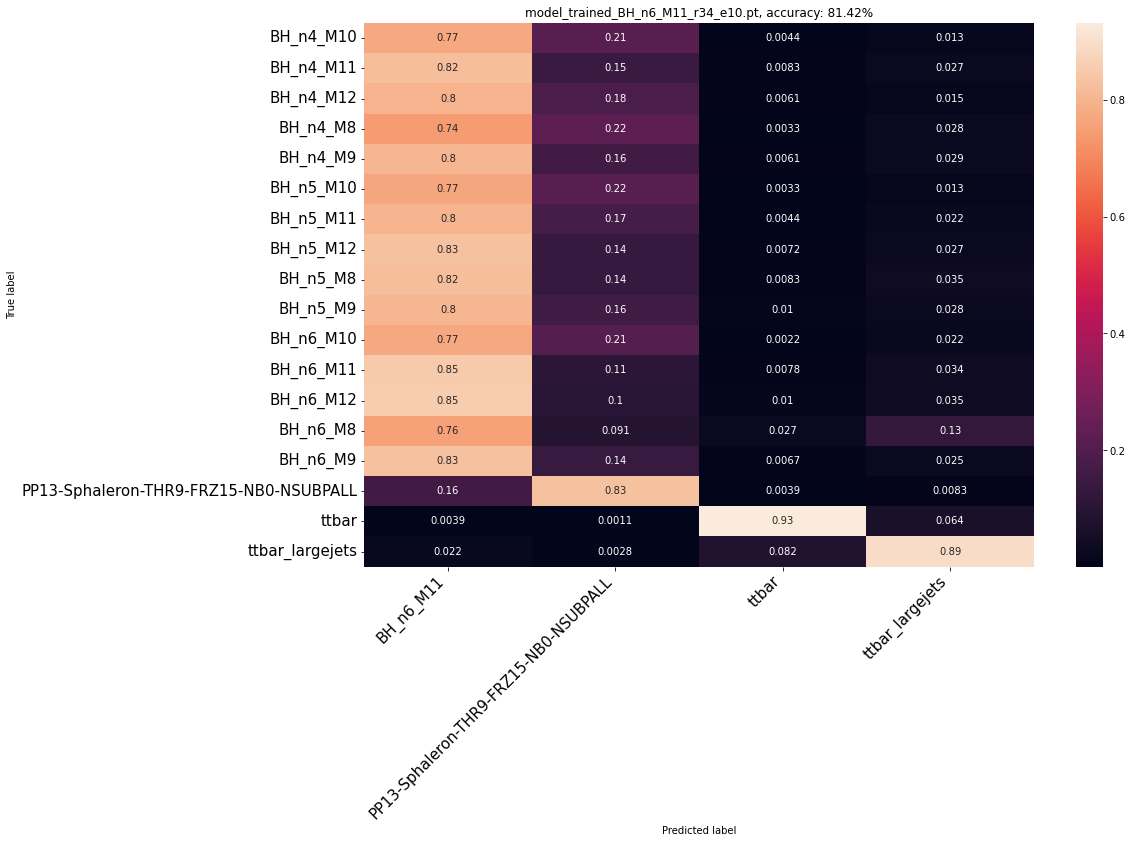

['BH_n6_M12', 'PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL', 'ttbar', 'ttbar_largejets']
['BH_n4_M10', 'BH_n4_M11', 'BH_n4_M12', 'BH_n4_M8', 'BH_n4_M9', 'BH_n5_M10', 'BH_n5_M11', 'BH_n5_M12', 'BH_n5_M8', 'BH_n5_M9', 'BH_n6_M10', 'BH_n6_M11', 'BH_n6_M12', 'BH_n6_M8', 'BH_n6_M9', 'PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL', 'ttbar', 'ttbar_largejets']
for model_trained_BH_n6_M12_r34_e10.pt: Got 23677 / 32400 with accuracy 73.08%


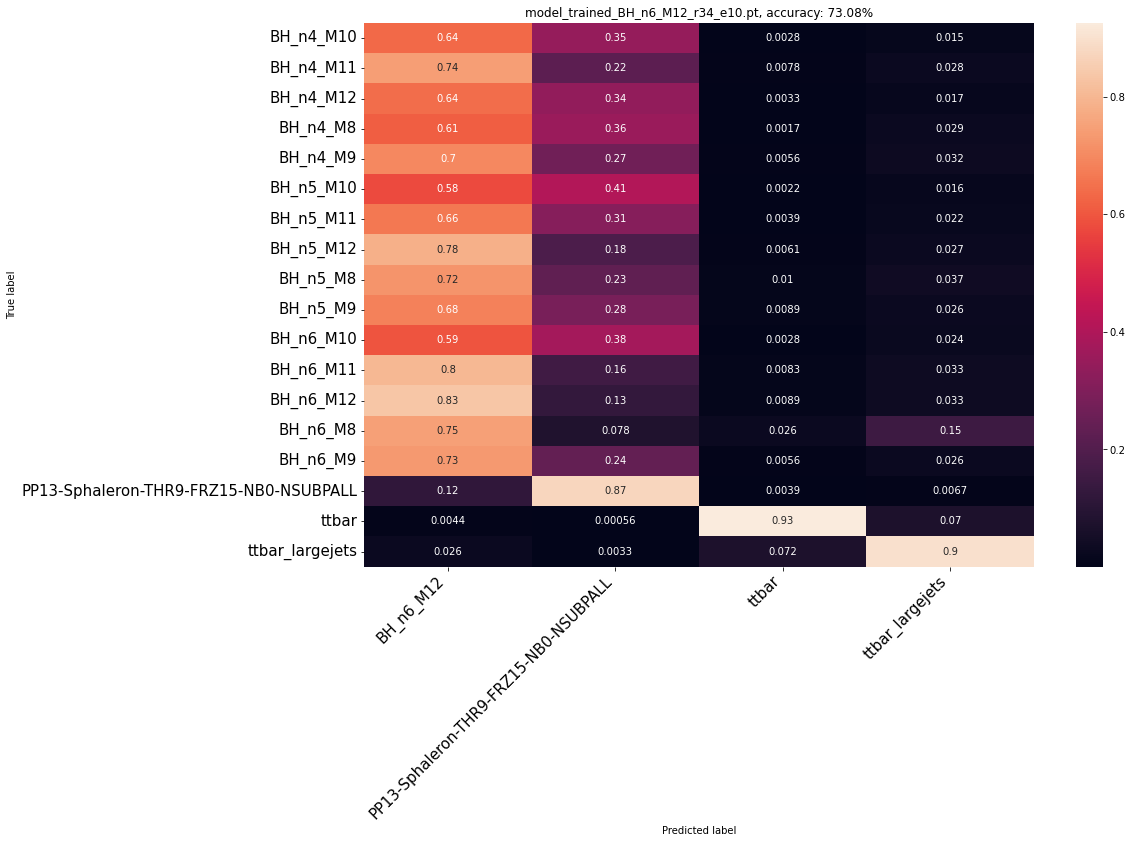

['BH_n6_M8', 'PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL', 'ttbar', 'ttbar_largejets']
['BH_n4_M10', 'BH_n4_M11', 'BH_n4_M12', 'BH_n4_M8', 'BH_n4_M9', 'BH_n5_M10', 'BH_n5_M11', 'BH_n5_M12', 'BH_n5_M8', 'BH_n5_M9', 'BH_n6_M10', 'BH_n6_M11', 'BH_n6_M12', 'BH_n6_M8', 'BH_n6_M9', 'PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL', 'ttbar', 'ttbar_largejets']
for model_trained_BH_n6_M8_r34_e10.pt: Got 12655 / 32400 with accuracy 39.06%


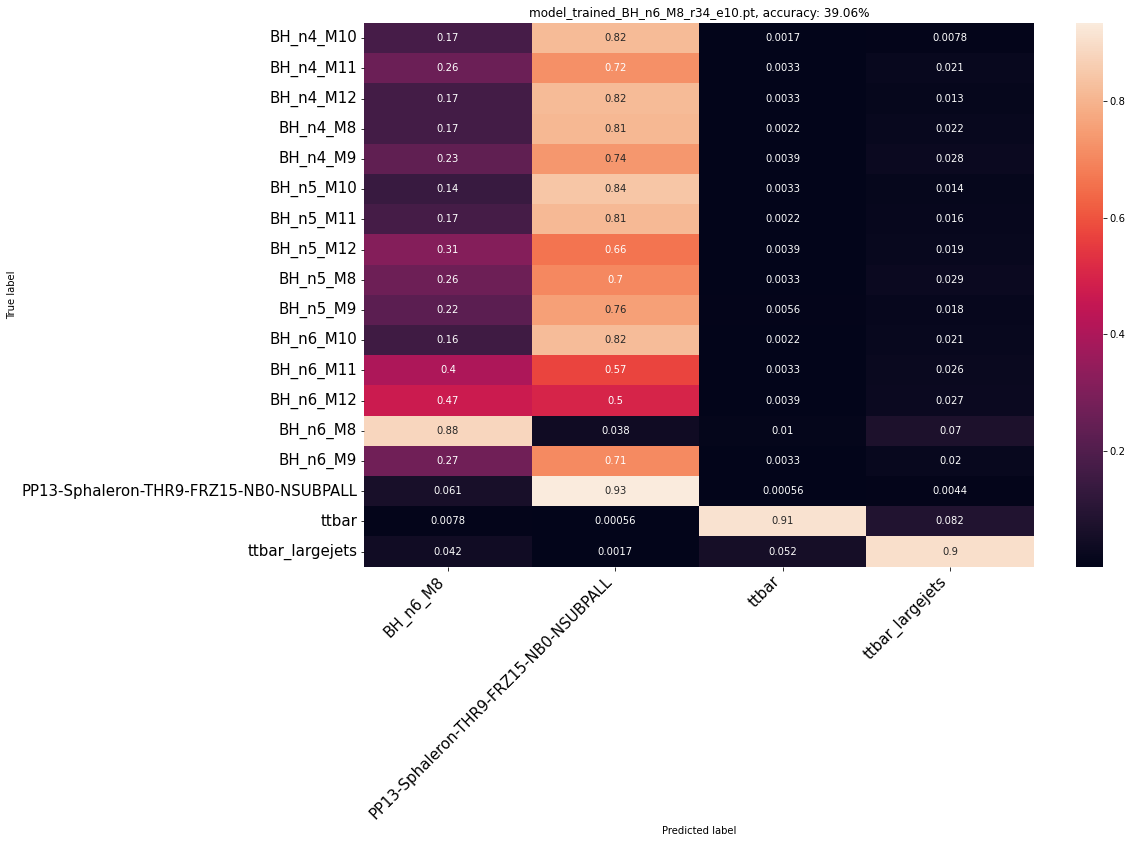

['BH_n6_M9', 'PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL', 'ttbar', 'ttbar_largejets']
['BH_n4_M10', 'BH_n4_M11', 'BH_n4_M12', 'BH_n4_M8', 'BH_n4_M9', 'BH_n5_M10', 'BH_n5_M11', 'BH_n5_M12', 'BH_n5_M8', 'BH_n5_M9', 'BH_n6_M10', 'BH_n6_M11', 'BH_n6_M12', 'BH_n6_M8', 'BH_n6_M9', 'PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL', 'ttbar', 'ttbar_largejets']
for model_trained_BH_n6_M9_r34_e10.pt: Got 27207 / 32400 with accuracy 83.97%


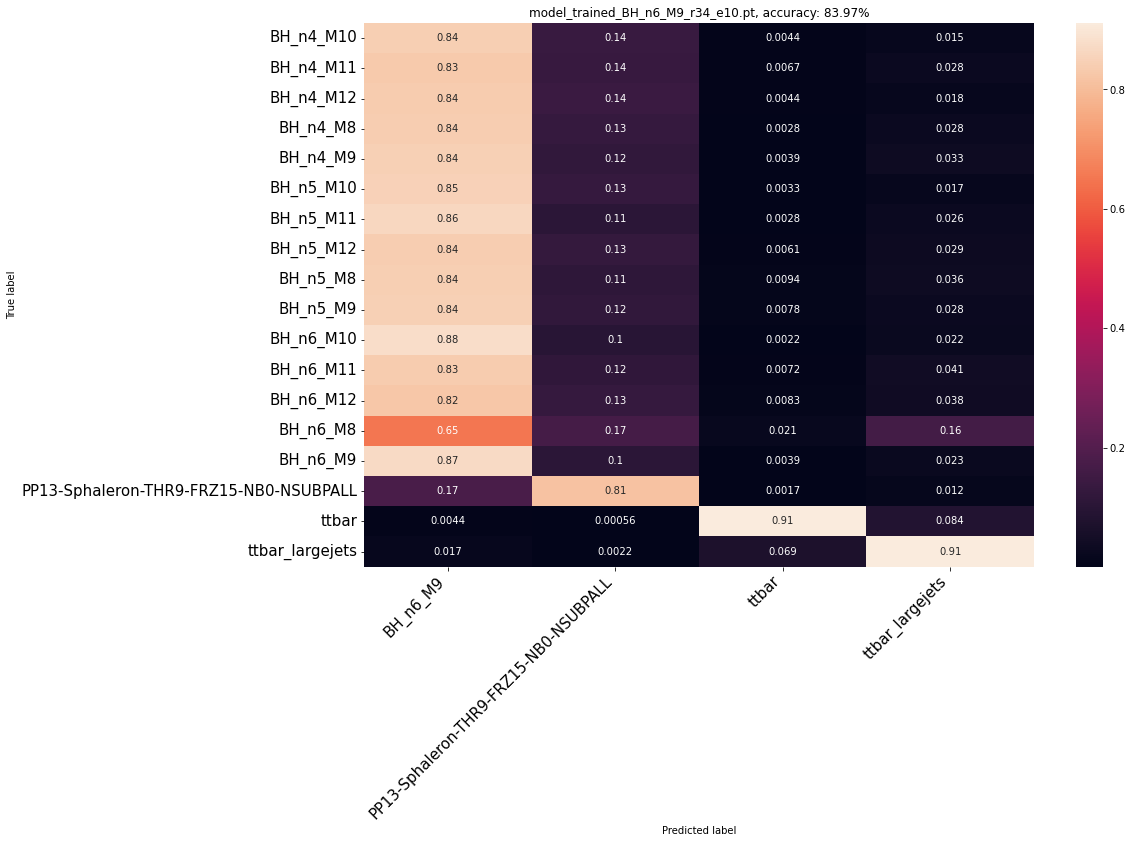

In [ ]:
from torchvision.models import ResNet
data_dir = 'generatedData'

def loadAndPlotAll(folder, loaded_model):
  valDataDir = f"{data_dir}/val"
  subdirs = ["PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", "ttbar", "ttbar_largejets"]
  bh_folders = sorted(entry.name for entry in os.scandir(valDataDir) if (entry.is_dir() and entry.name.startswith("BH")) )
  for subfolder in bh_folders:
    subdirs.append(subfolder)

  image_dataset = ImageFolderCustom(valDataDir, subdirs, transform=data_transforms['val'])

  dataloader = torch.utils.data.DataLoader(image_dataset, batch_size=4,
                                               num_workers=4, shuffle=True)

  dataset_size = len(image_dataset)
  class_names =  [folder, "PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", "ttbar", "ttbar_largejets"] #image_datasets['train'].dataset.classes
  print(class_names)

  real_class_names = image_dataset.classes
  print(real_class_names)
  real_nb_classes = len(real_class_names)

  model_path = f"model_trained_{folder}_r34_e10.pt"
  if (not Path(model_path).is_file()):
    return
  model_ft = loaded_model
  model_ft.fc = nn.Linear(model_ft.fc.in_features, len(class_names))

  model_ft.load_state_dict(torch.load(model_path))
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  model_ft = model_ft.to(device)

  model_ft.eval()

  nb_classes = len(class_names)

  num_correct = 0
  num_samples = 0

  confusion_matrix = torch.zeros(real_nb_classes, nb_classes)
  with torch.no_grad():
      for i, (inputs, classes) in enumerate(dataloader):
          inputs = inputs.to(device)
          classes = classes.to(device)
          outputs = model_ft(inputs)
          _, preds = torch.max(outputs, 1)
          for t, p in zip(classes.view(-1), preds.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1
            num_samples += 1
            if (class_names[p].startswith("BH") or class_names[p].startswith("BlackHole")) and real_class_names[t].startswith("BH"):
              num_correct += 1
            elif class_names[p] == real_class_names[t]:
              num_correct += 1
            #else:
              #print(f"fail pred: {class_names[p]} not equal real: {real_class_names[t]} ")


  plt.figure(figsize=(15,10))
  accuracy = f"{float(num_correct)/float(num_samples)*100:.2f}"
  print(f'for {model_path}: Got {num_correct} / {num_samples} with accuracy {accuracy}%') 

  df_cm = pd.DataFrame(confusion_matrix, index=real_class_names, columns=class_names).astype(int)
  normalized_df = df_cm.div(df_cm.sum(axis=1), axis=0)
  heatmap = sns.heatmap(normalized_df, annot=True)

  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.title(f"{model_path}, accuracy: {accuracy}%")
  plt.show()

bh_folders = sorted(entry.name for entry in os.scandir(f"{data_dir}/val") if (entry.is_dir() and ( entry.name.startswith("BH") or entry.name.startswith("BlackHole")) )

for folder in bh_folders:
  loadAndPlotAll(folder, models.resnet34(pretrained=True))
#loadAndPlotAll("BlackHole", models.resnet50(pretrained=True))

